In [139]:
from nb_utils import set_path
import pandas as pd
import numpy as np
from waterlevels_oker import utils
from waterlevels_oker.data import get_climate_data, get_forecast, preprocess_ohrum_data, get_ohrum_data
import missingno as msno

In [3]:
climate_raw = pd.read_csv(utils.get_raw_path("climate_data.csv"), parse_dates=[0], index_col=0)

In [4]:
drop_cols = ["source_id", "condition", "precipitation_probability", "precipitation_probability_6h", "fallback_source_ids", "icon"]
climate_raw = climate_raw.drop(columns=drop_cols)

In [5]:
climate_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127825 entries, 2010-01-01 00:00:00+00:00 to 2024-08-01 00:00:00+00:00
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   precipitation        127575 non-null  float64
 1   pressure_msl         127610 non-null  float64
 2   sunshine             96392 non-null   float64
 3   temperature          127588 non-null  float64
 4   wind_direction       126372 non-null  float64
 5   wind_speed           126465 non-null  float64
 6   cloud_cover          126070 non-null  float64
 7   dew_point            127376 non-null  float64
 8   relative_humidity    127376 non-null  float64
 9   visibility           126743 non-null  float64
 10  wind_gust_direction  126327 non-null  float64
 11  wind_gust_speed      126460 non-null  float64
 12  solar                126512 non-null  float64
dtypes: float64(13)
memory usage: 13.7 MB


In [6]:
climate_raw.isna().any(axis=1).sum()

34007

In [7]:
climate_raw.isna().mean(axis=0).sort_values(ascending=False)

sunshine               0.245907
cloud_cover            0.013730
wind_gust_direction    0.011719
wind_direction         0.011367
wind_gust_speed        0.010679
wind_speed             0.010640
solar                  0.010272
visibility             0.008465
dew_point              0.003513
relative_humidity      0.003513
precipitation          0.001956
temperature            0.001854
pressure_msl           0.001682
dtype: float64

In [8]:
climate_raw[climate_raw.sunshine.isna()].index.hour.value_counts()
# when hour is 0, 1, 2 21, 22, 23 fill with 0

timestamp
0     5052
2     5052
21    5052
22    5052
23    5052
1     5052
14      69
18      68
17      68
15      68
16      67
19      67
11      65
10      65
12      63
13      62
9       61
20      60
8       60
3       56
4       56
5       56
6       55
7       55
Name: count, dtype: int64

In [9]:
night_missing_sunshine = climate_raw.loc[climate_raw["sunshine"].isna() & climate_raw.index.hour.isin([21, 22, 23, 0, 1, 2])].index

In [10]:
climate_raw.loc[night_missing_sunshine, "sunshine"] = 0
climate_raw

,precipitation,pressure_msl,sunshine,temperature,wind_direction,wind_speed,cloud_cover,dew_point,relative_humidity,visibility,wind_gust_direction,wind_gust_speed,solar
timestamp,,,,,,,,,,,,,
2010-01-01 00:00:00+00:00,0.0,997.0,0.0,-1.8,60.0,18.7,100.0,-3.4,89.0,9000.0,80.0,24.8,NaN
2010-01-01 01:00:00+00:00,0.0,996.6,0.0,-1.8,70.0,16.9,100.0,-3.5,88.0,12000.0,50.0,28.8,0.000
2010-01-01 02:00:00+00:00,0.0,996.7,0.0,-1.8,60.0,16.6,100.0,-3.4,89.0,16000.0,70.0,27.4,0.000
2010-01-01 03:00:00+00:00,0.0,996.5,0.0,-1.8,60.0,16.9,100.0,-3.5,88.0,15000.0,60.0,26.6,0.000
2010-01-01 04:00:00+00:00,0.2,996.5,0.0,-2.1,50.0,15.5,100.0,-3.4,91.0,7000.0,50.0,24.5,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 20:00:00+00:00,0.0,1014.0,0.0,21.7,230.0,5.8,100.0,19.0,85.0,36630.0,200.0,10.8,0.007
2024-07-31 21:00:00+00:00,0.0,1013.8,0.0,20.0,240.0,4.3,100.0,18.6,92.0,32200.0,240.0,7.2,0.000
2024-07-31 22:00:00+00:00,0.0,1013.5,0.0,19.1,240.0,2.9,50.0,18.1,94.0,27800.0,230.0,4.7,0.000


<Axes: >

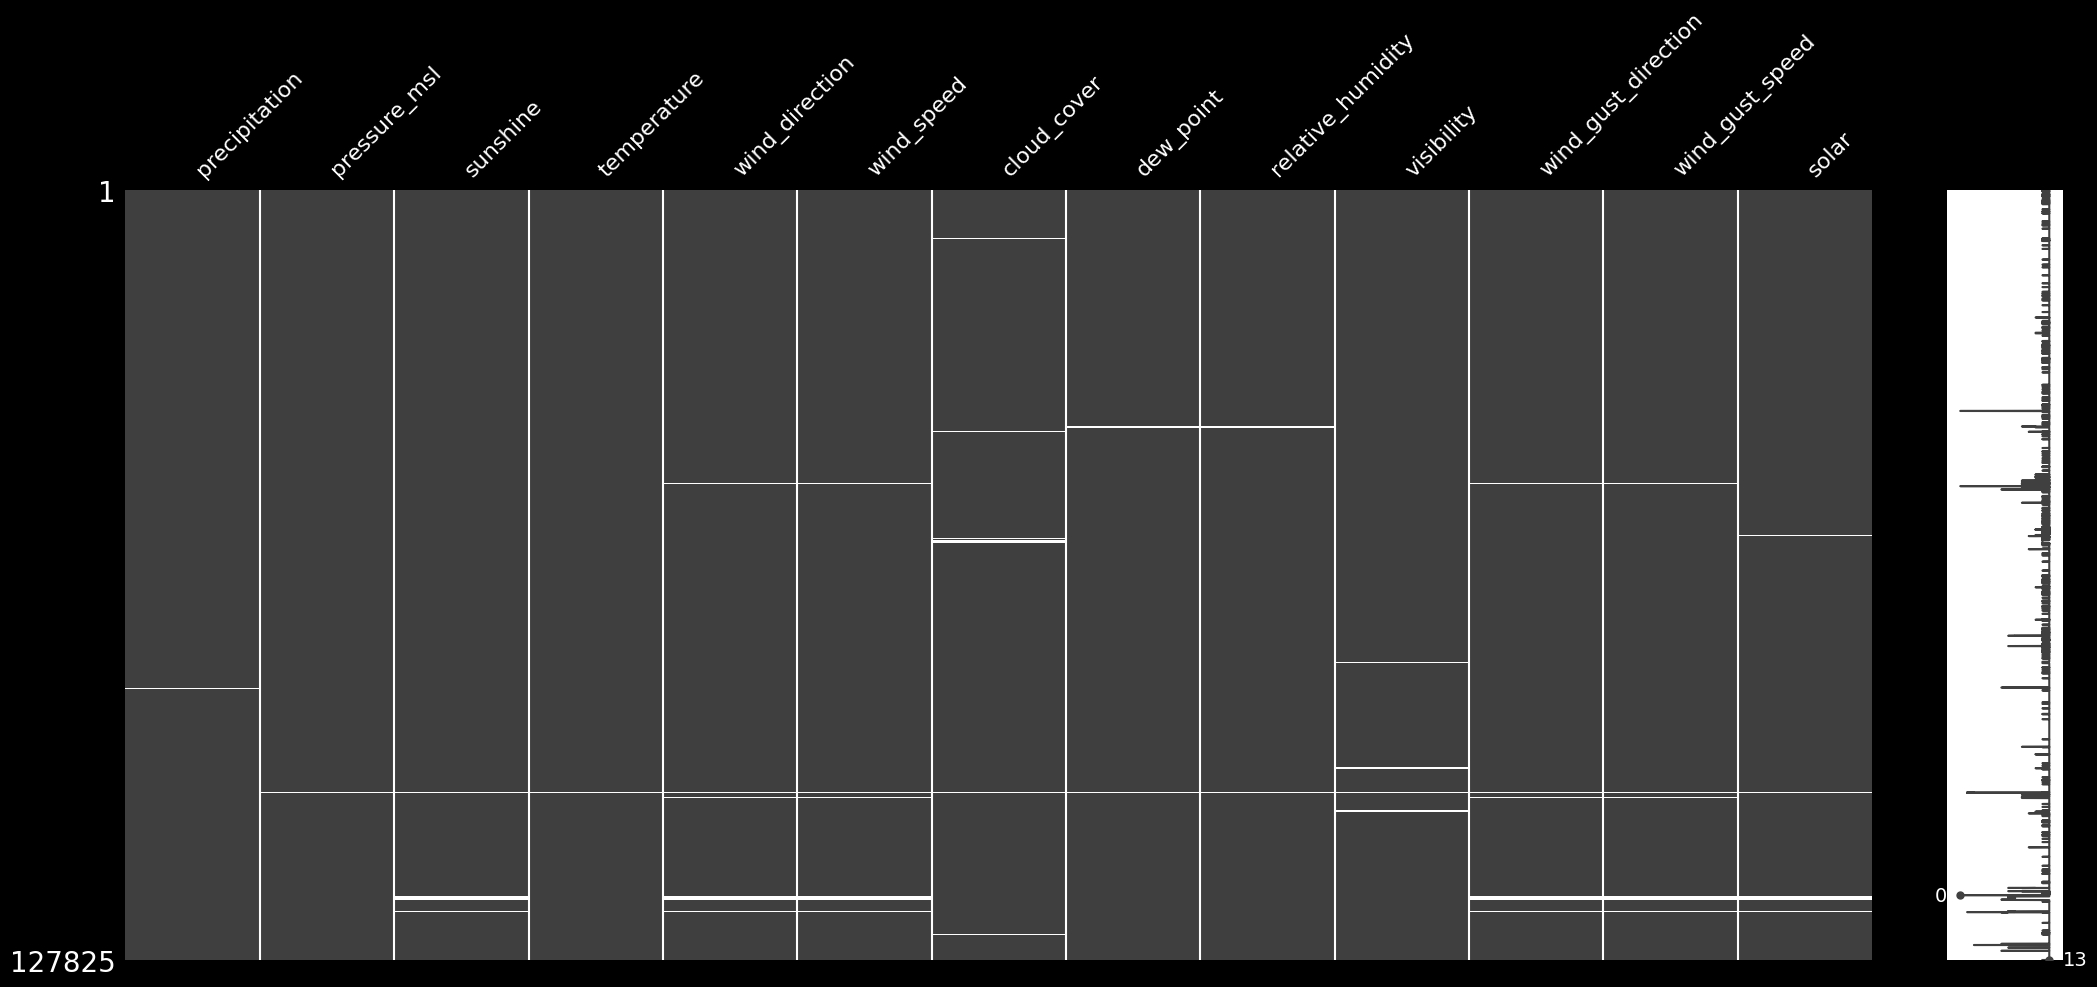

In [11]:
msno.matrix(climate_raw)

In [12]:
f"Percentage of columns with na: {round(climate_raw.isna().any(axis=1).sum()/len(climate_raw), 2)*100}"

'Percentage of columns with na: 4.0'

In [13]:
climate_raw.isna().any(axis=1).sum()

4756

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("default")


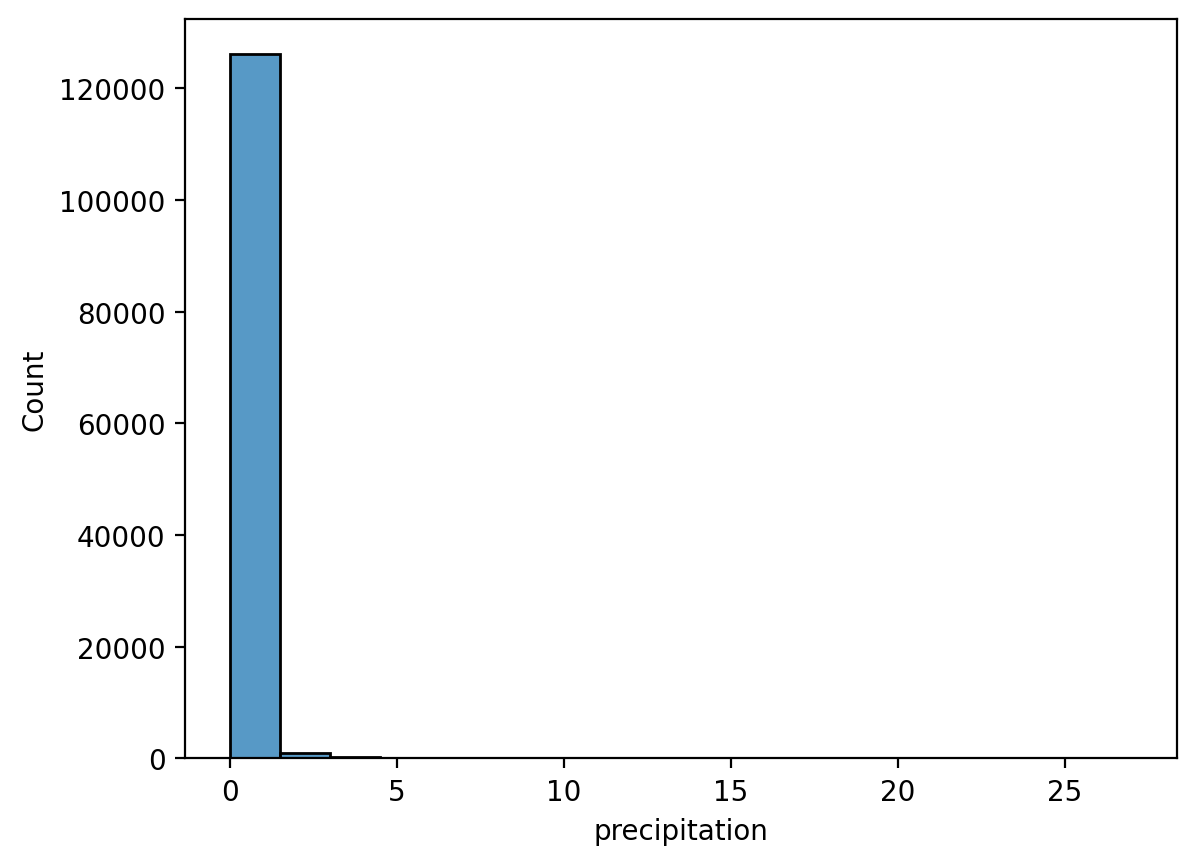

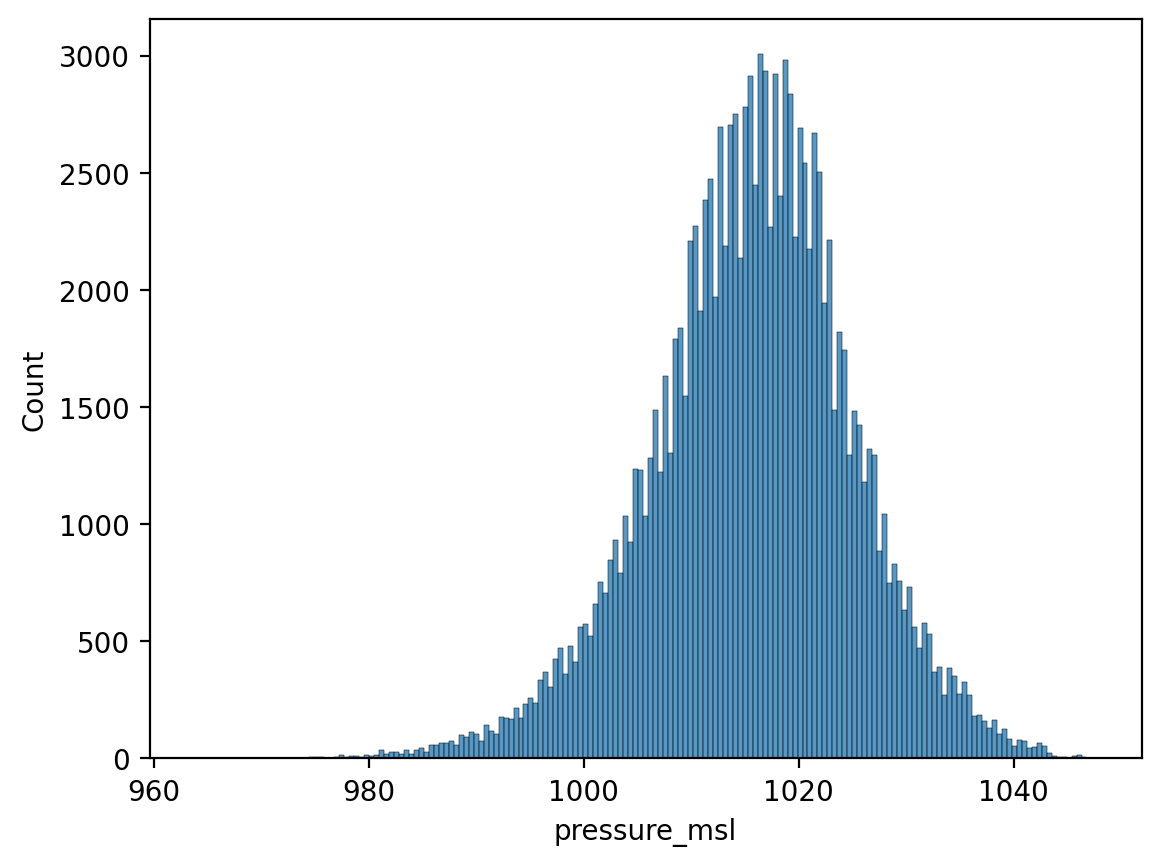

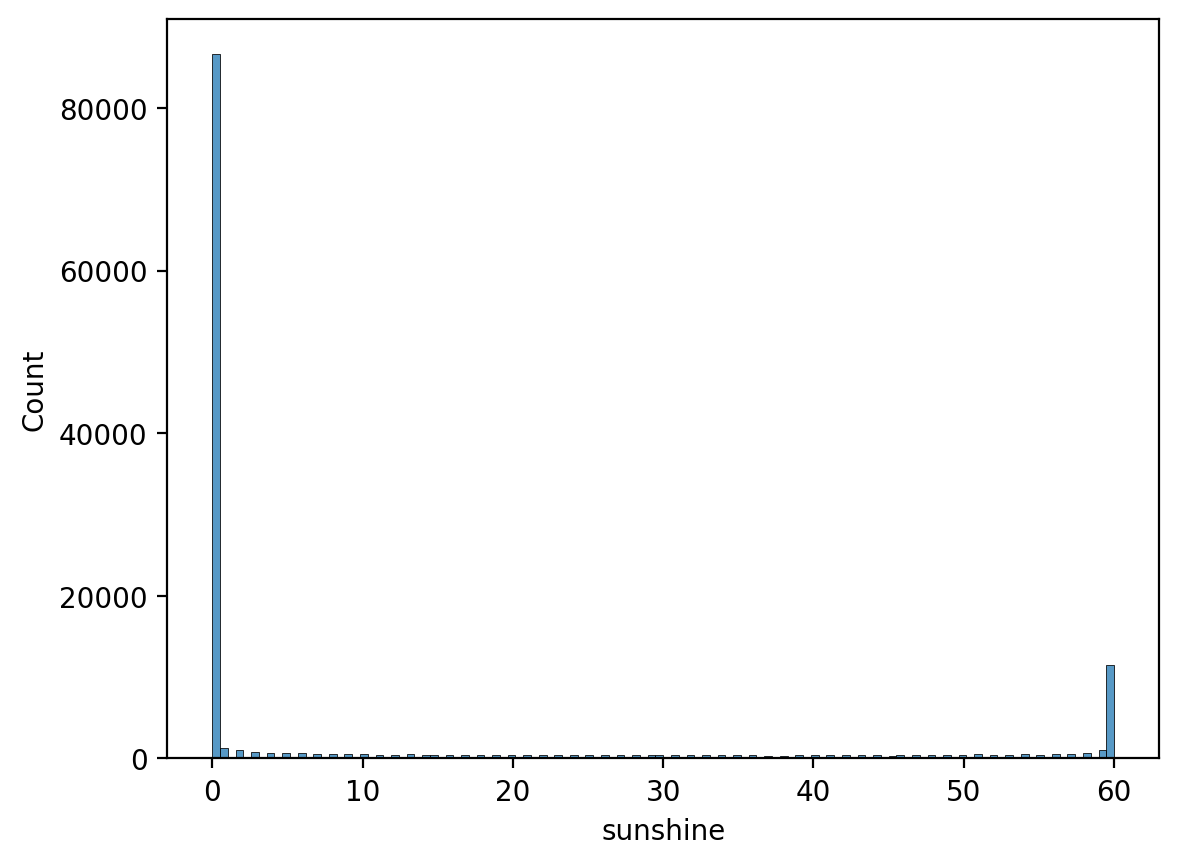

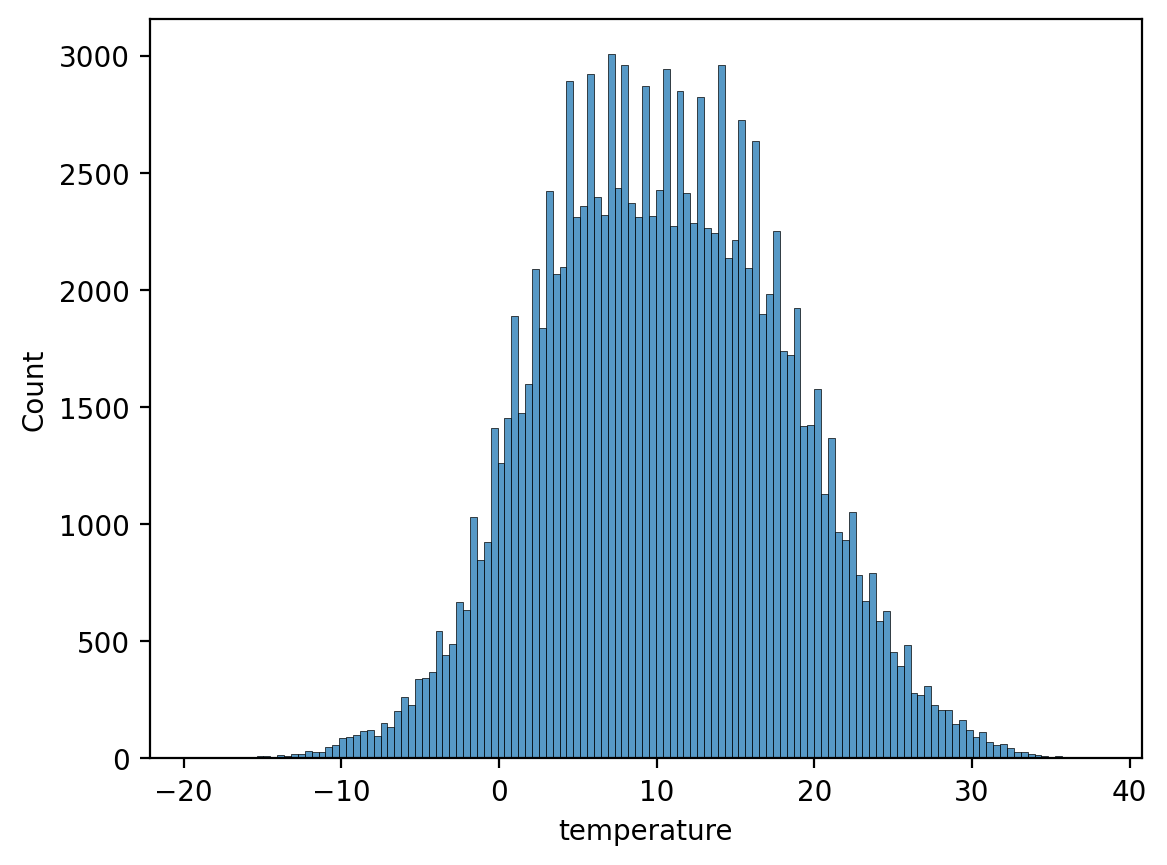

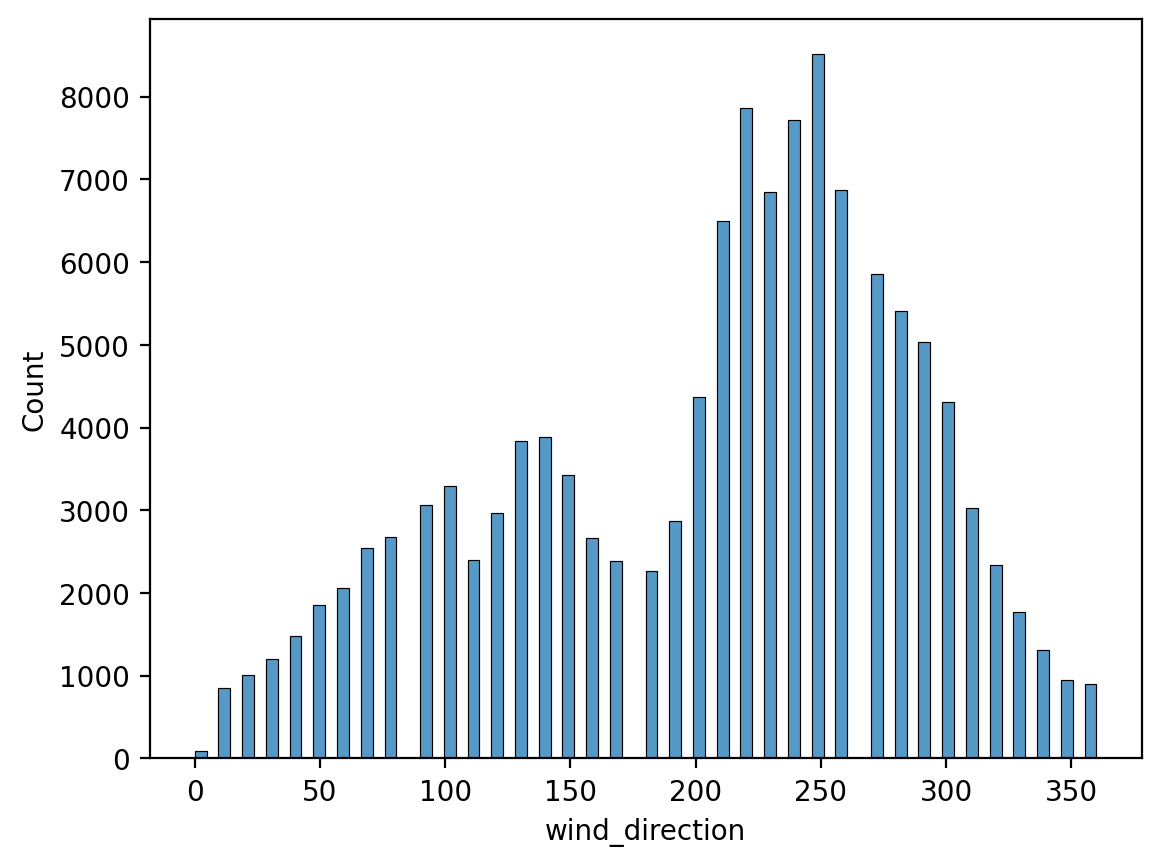

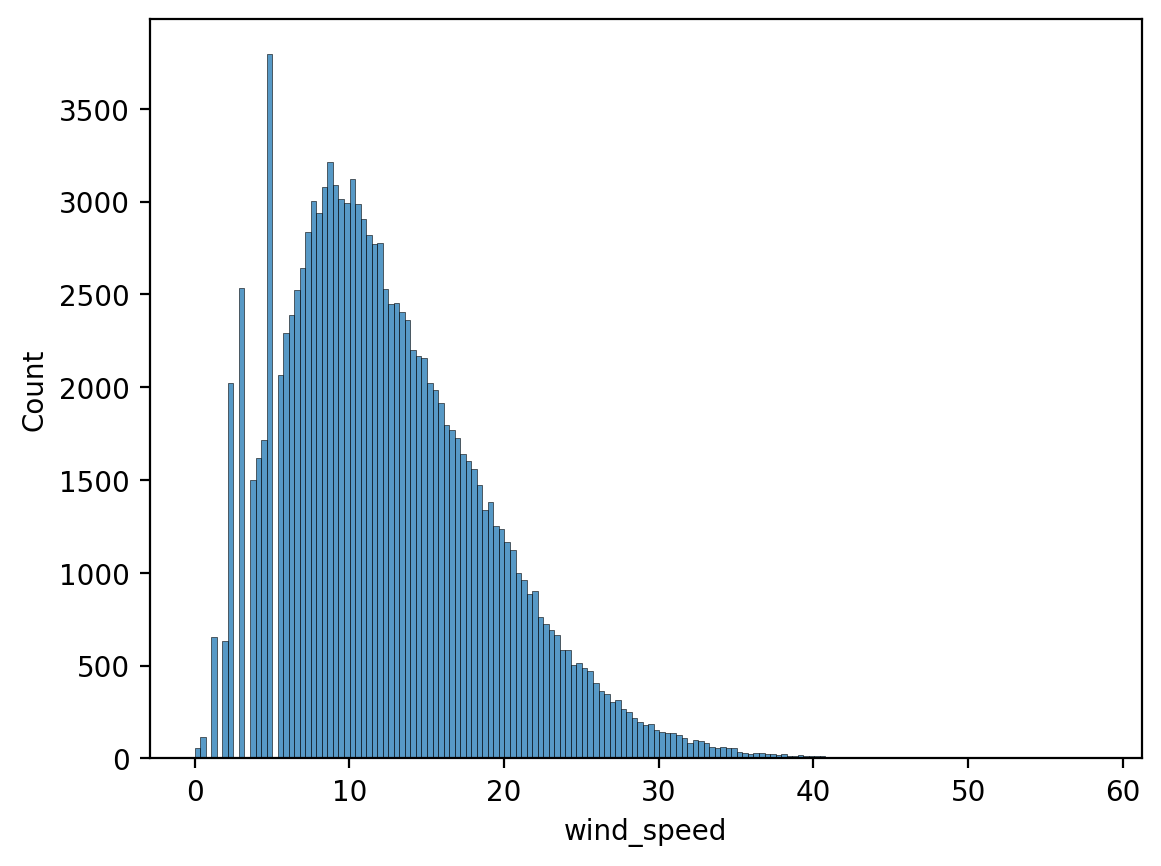

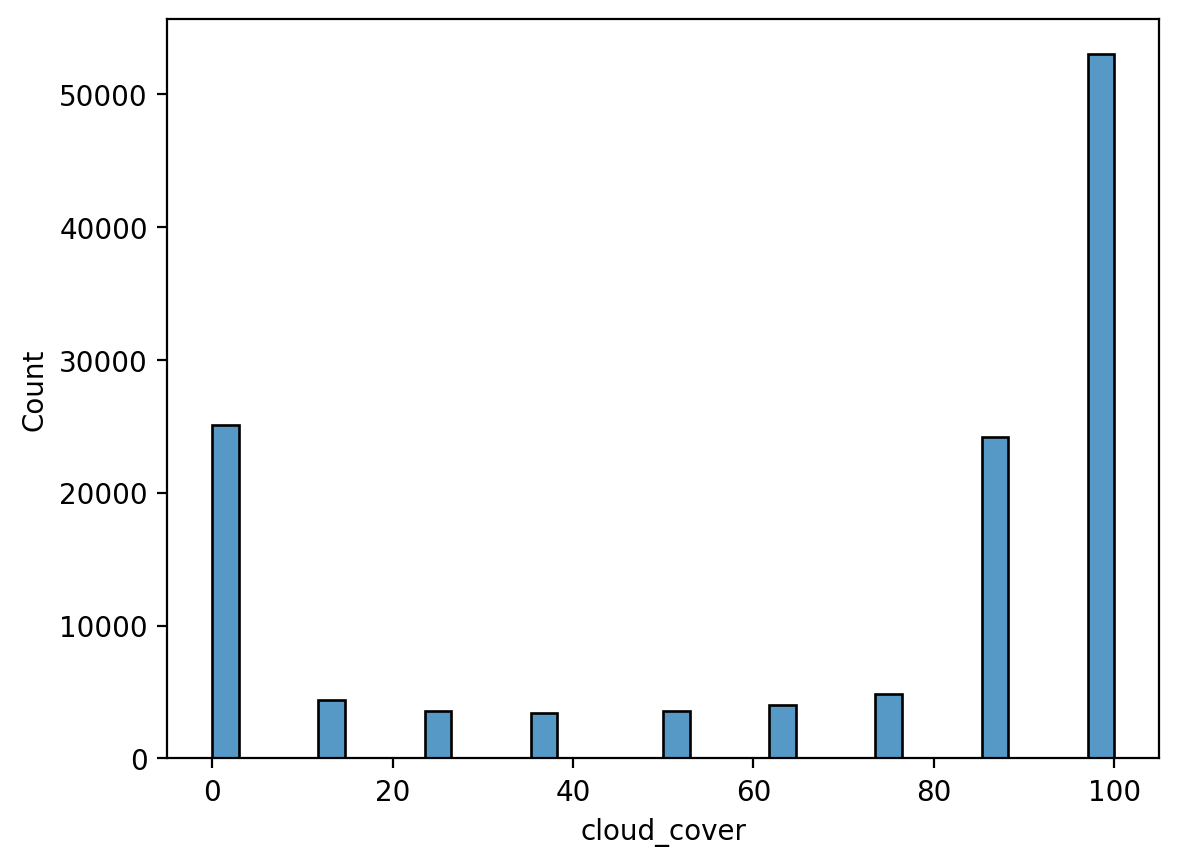

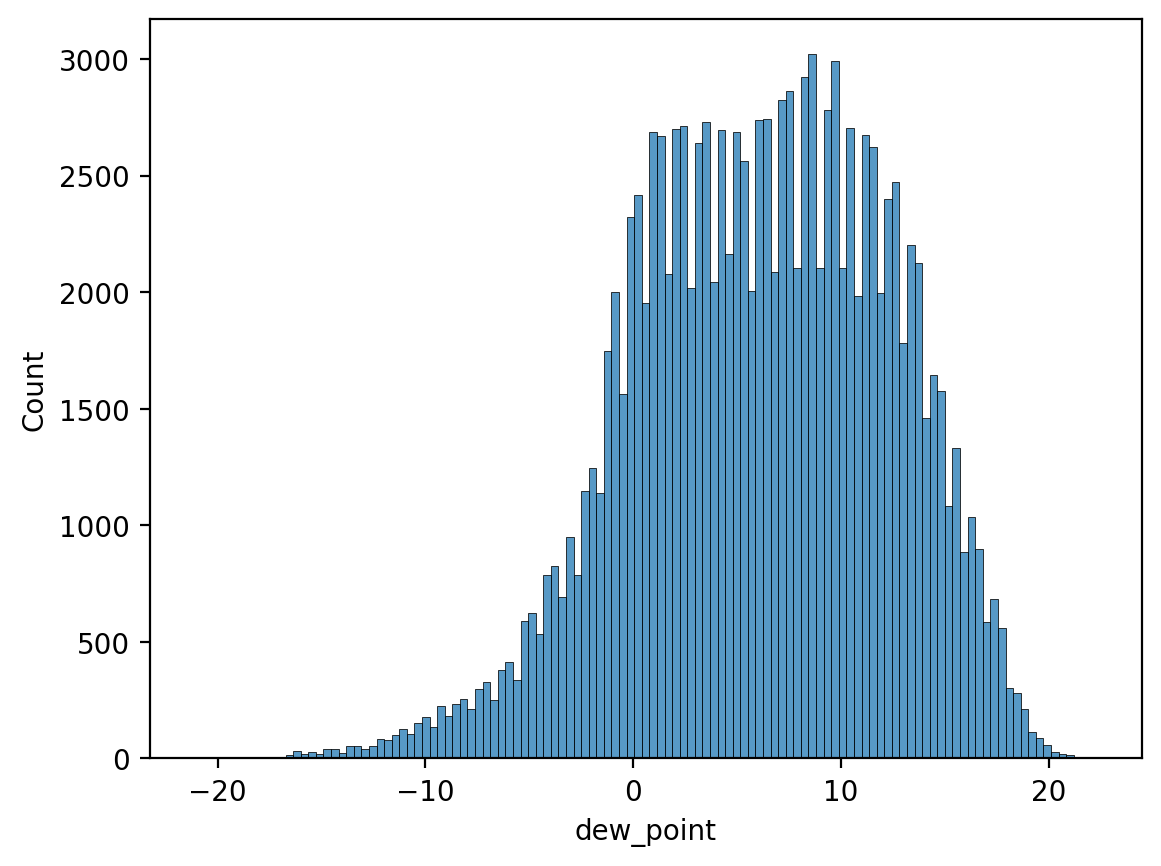

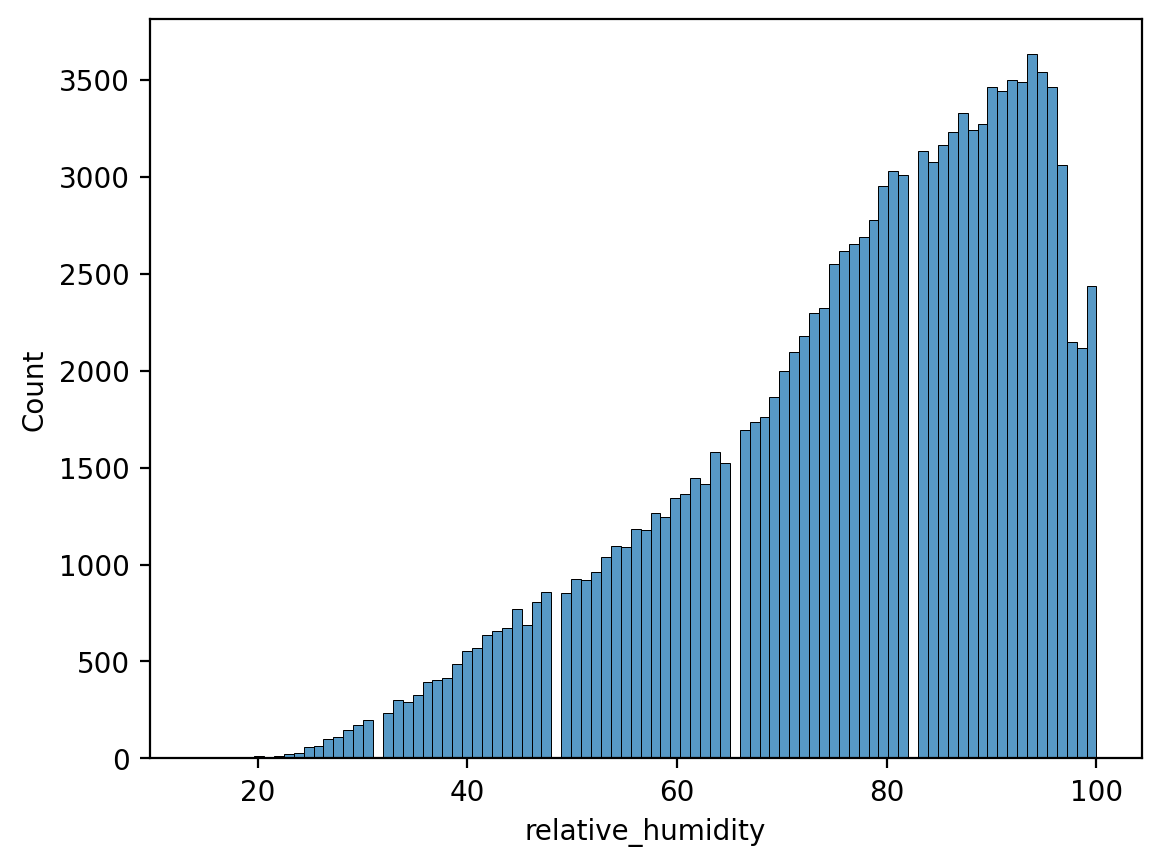

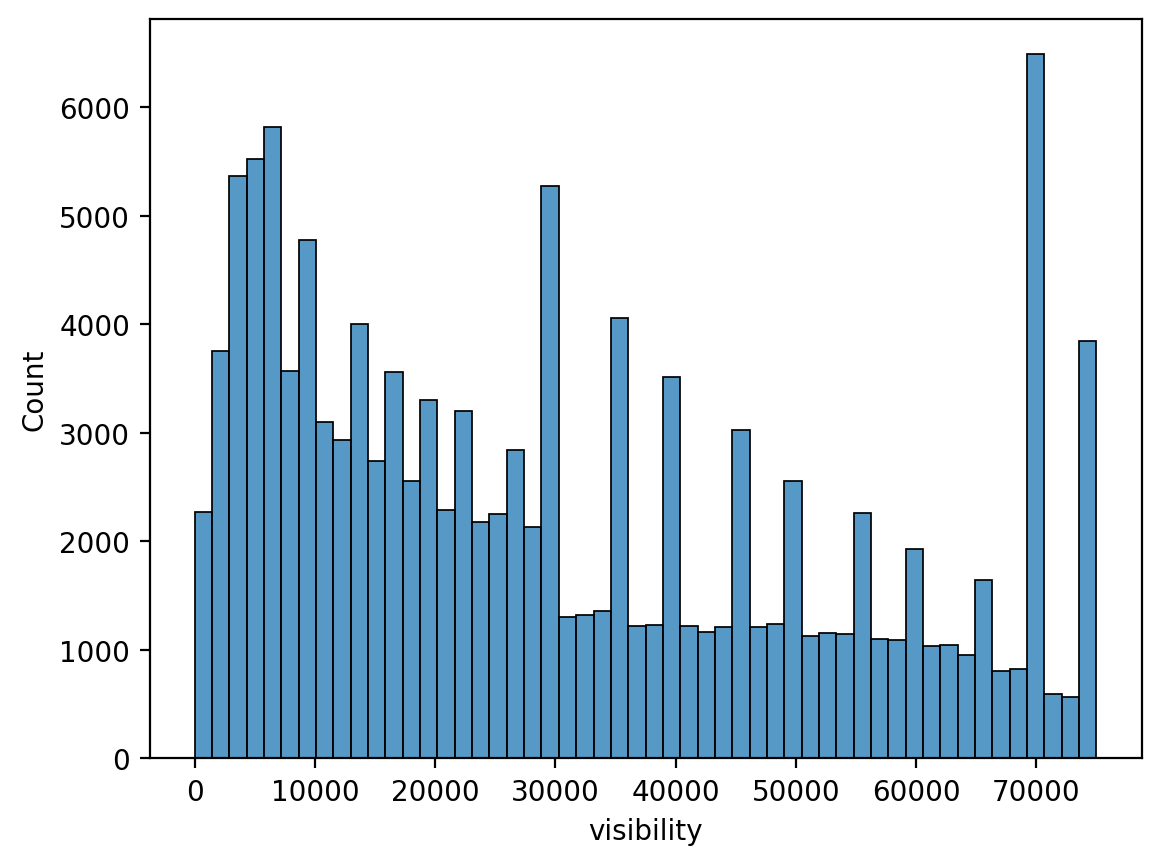

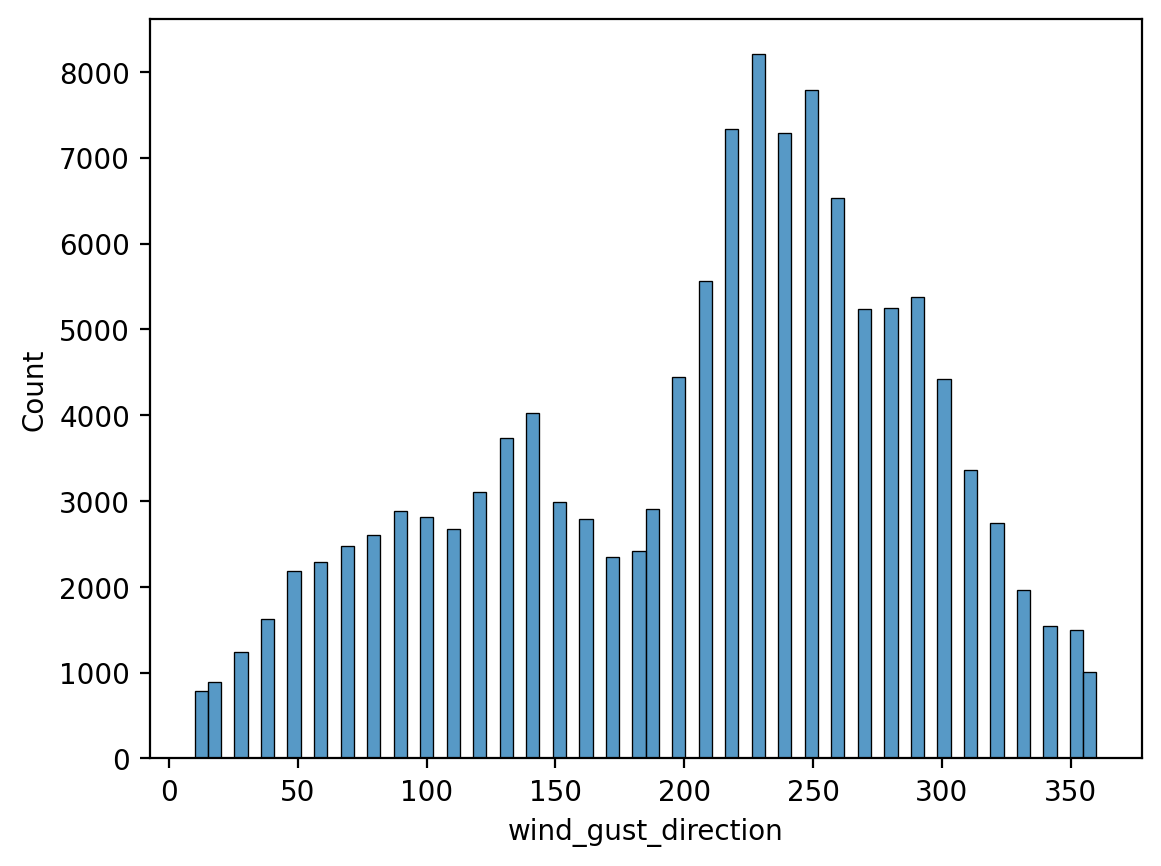

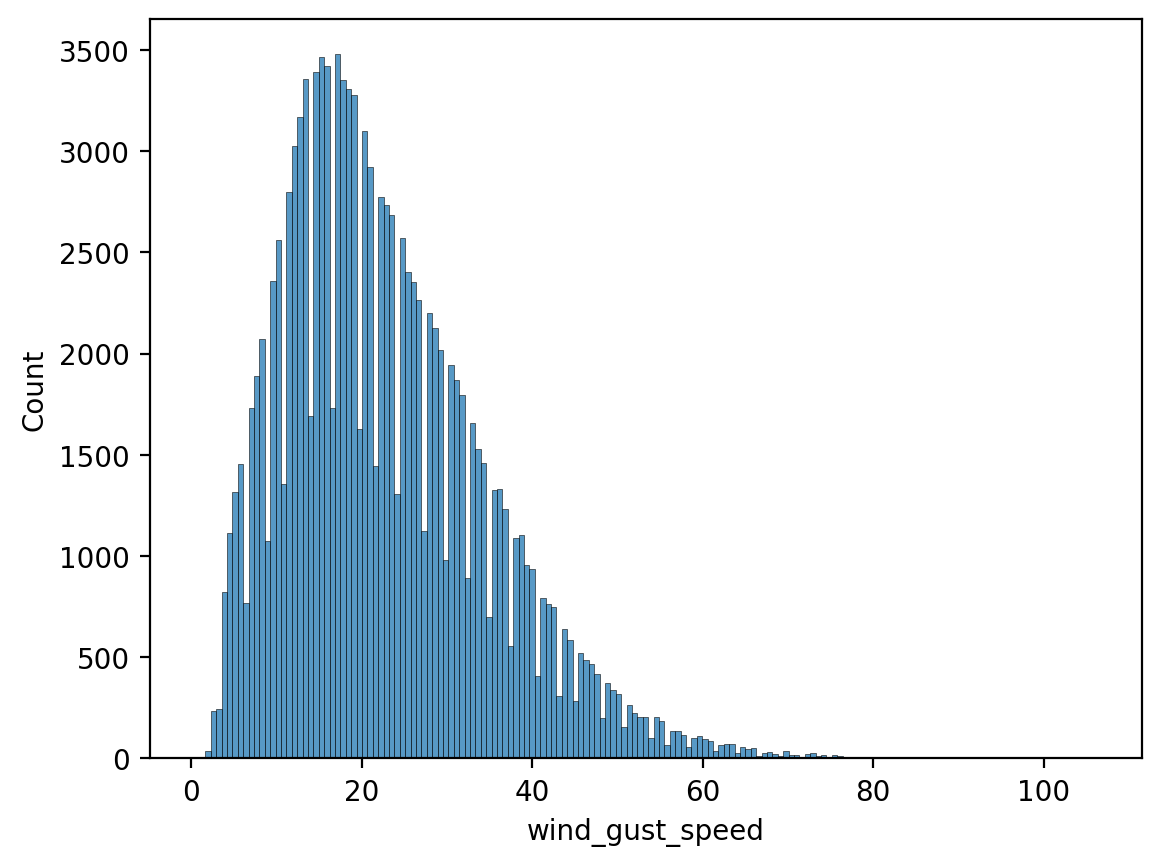

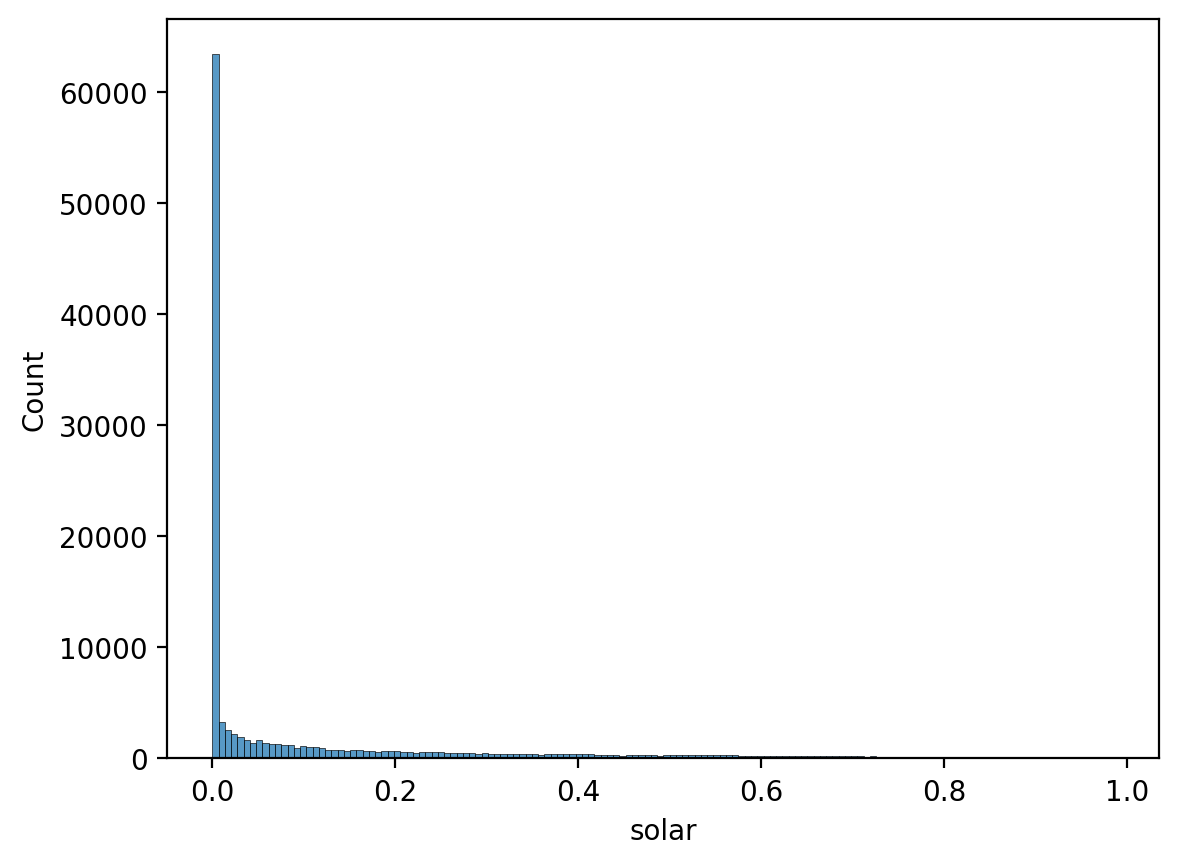

In [15]:
for col in climate_raw.select_dtypes("number"):
    sns.histplot(climate_raw[col])
    plt.show()

In [16]:
climate_raw.describe()

,precipitation,pressure_msl,sunshine,temperature,wind_direction,wind_speed,cloud_cover,dew_point,relative_humidity,visibility,wind_gust_direction,wind_gust_speed,solar
count,127575.000000,127610.000000,126704.000000,127588.000000,126372.000000,126465.000000,126070.000000,127376.000000,127376.000000,126743.000000,126327.000000,126460.000000,126512.000000
mean,0.069594,1015.641191,11.856279,10.472194,204.359510,12.482428,67.095820,6.073628,76.713290,30323.598305,205.743665,22.853437,0.124472
std,0.448654,9.419968,21.191523,7.665702,81.703958,6.552501,40.256564,6.210463,16.715192,22267.751882,83.065739,12.061851,0.202826
min,0.000000,963.800000,0.000000,-19.300000,0.000000,0.000000,0.000000,-21.100000,14.000000,0.000000,10.000000,0.400000,0.000000
25%,0.000000,1010.000000,0.000000,4.900000,140.000000,7.600000,25.000000,1.600000,66.000000,10540.000000,140.000000,14.000000,0.000000
50%,0.000000,1016.100000,0.000000,10.300000,220.000000,11.500000,87.000000,6.300000,80.000000,26000.000000,220.000000,20.900000,0.006000
75%,0.000000,1021.700000,13.000000,15.900000,260.000000,16.600000,100.000000,10.800000,90.000000,47240.000000,270.000000,29.900000,0.172000
max,27.000000,1047.700000,60.000000,37.900000,360.000000,58.300000,100.000000,22.300000,100.000000,75000.000000,360.000000,106.200000,0.986000


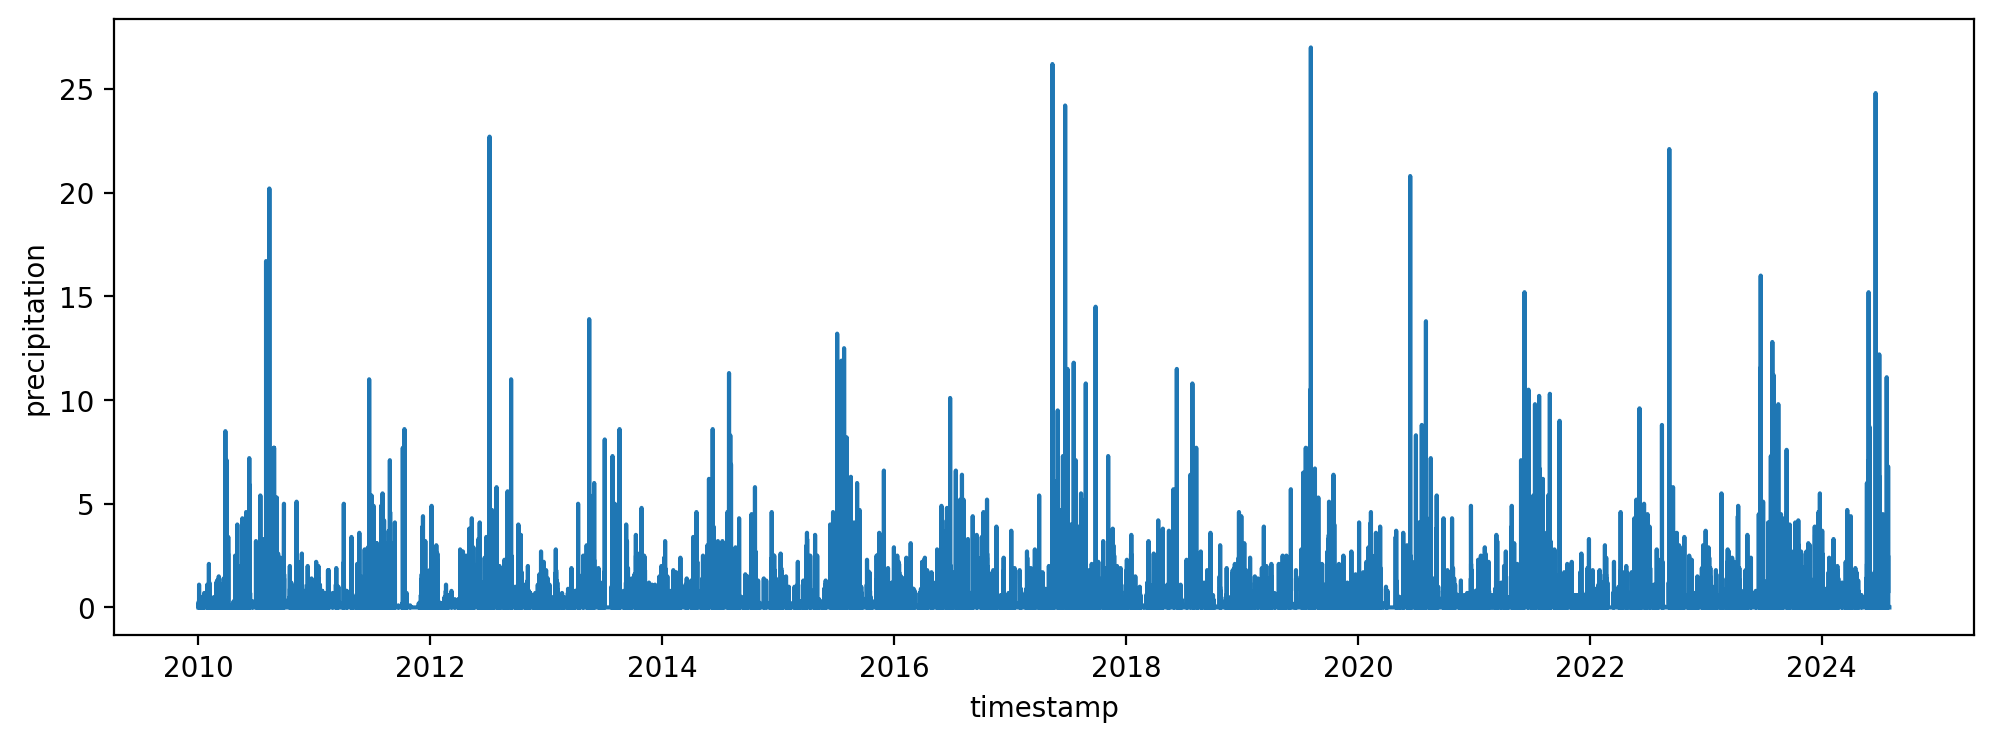

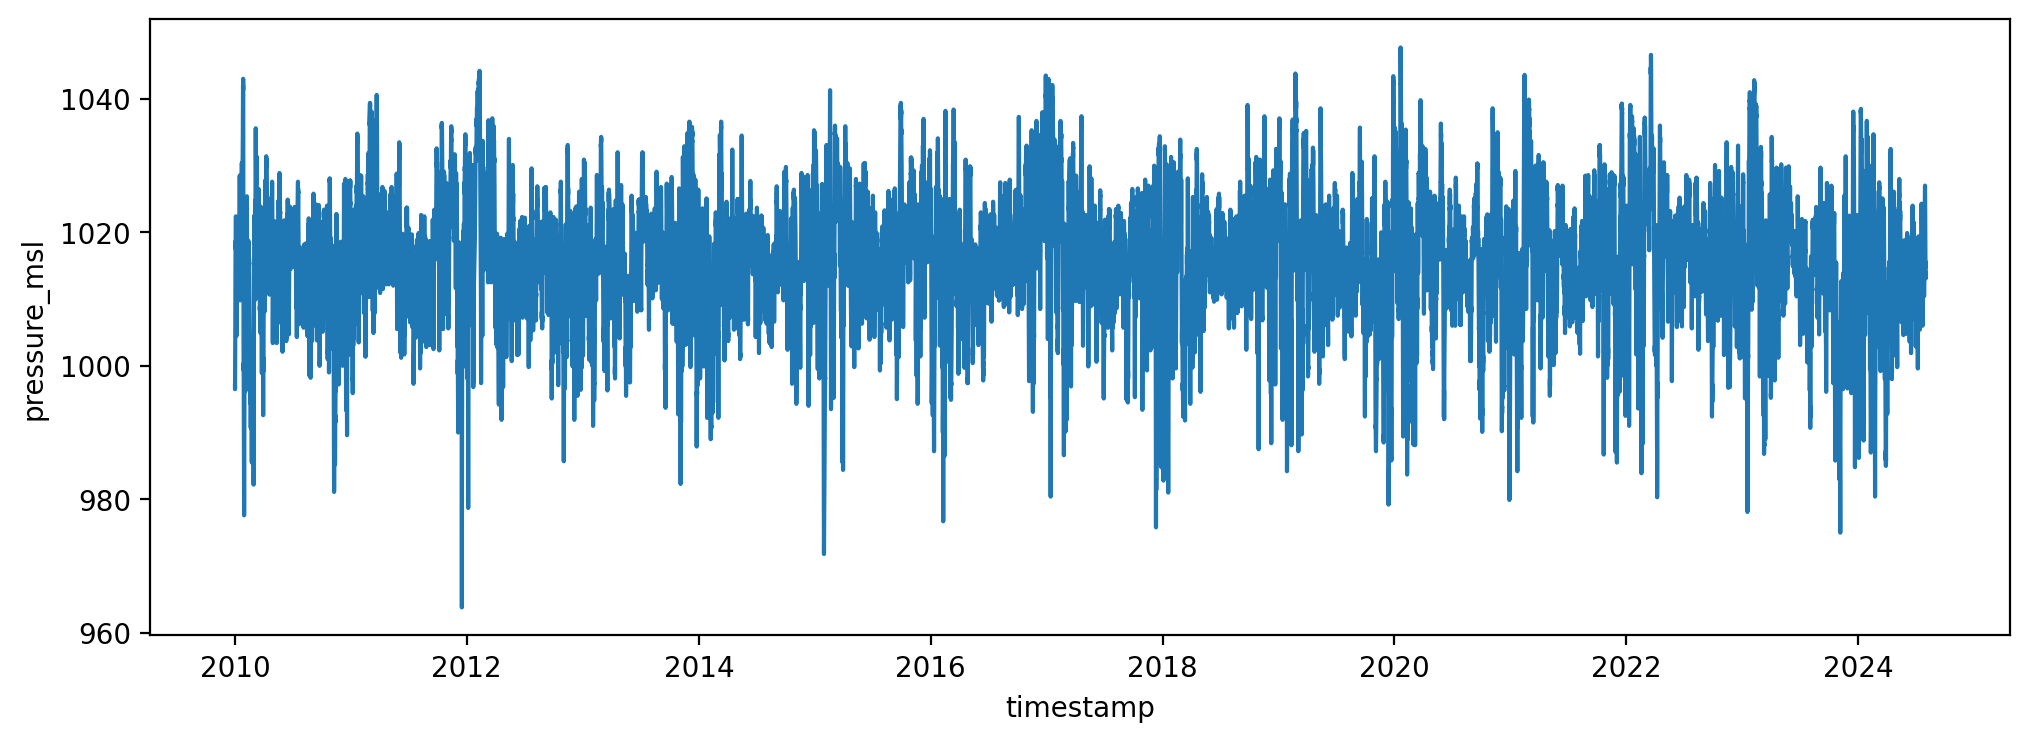

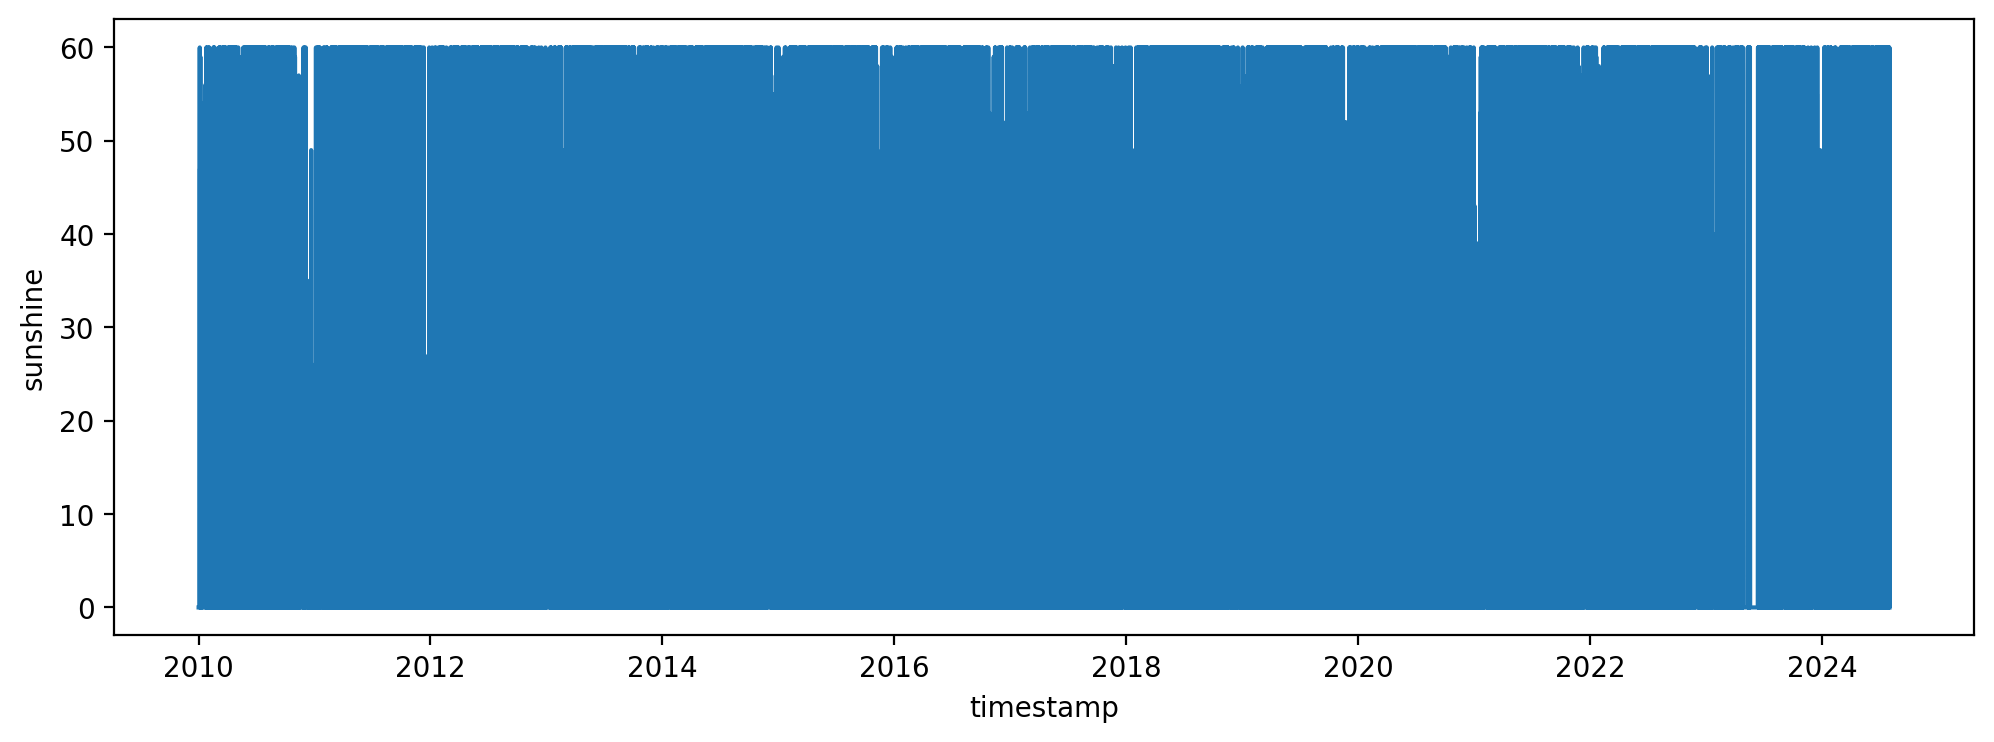

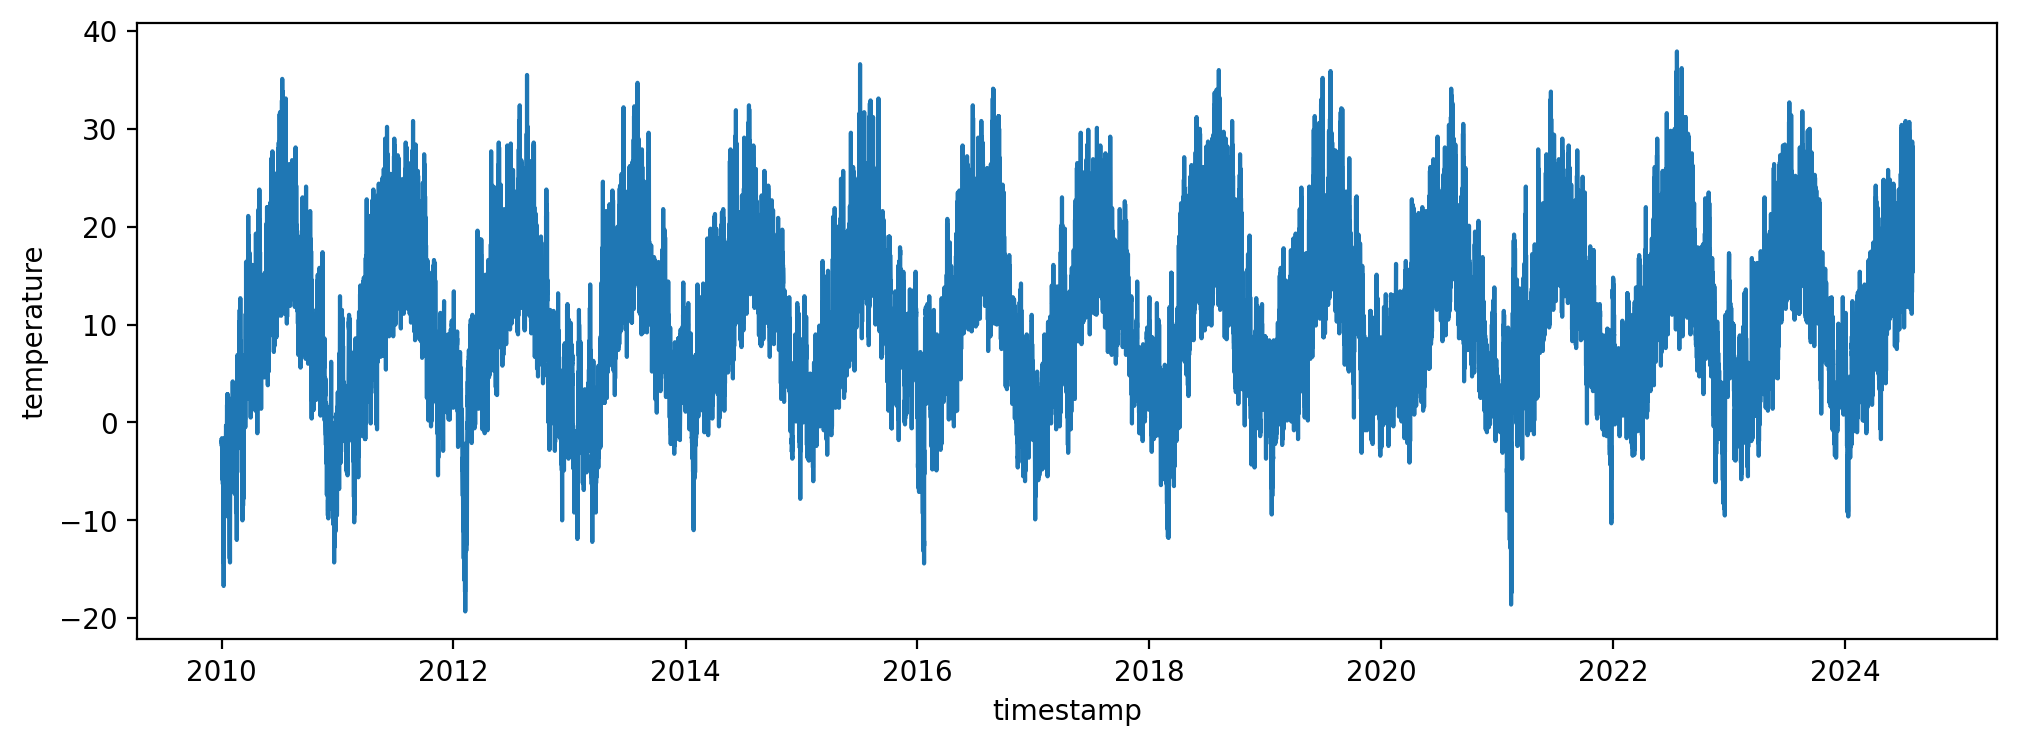

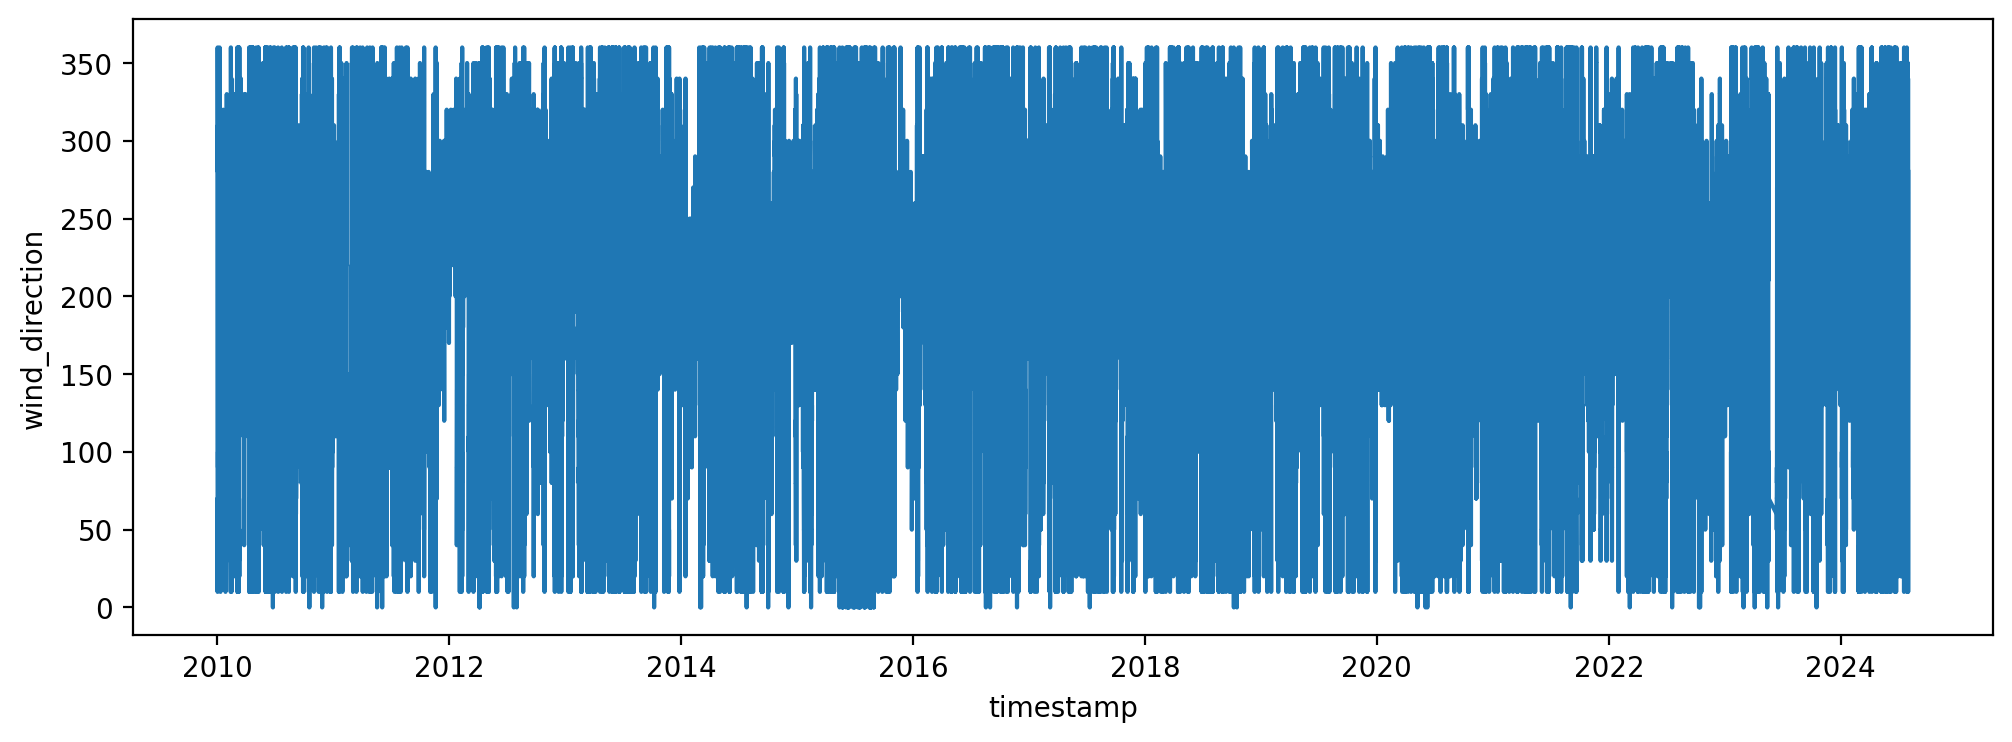

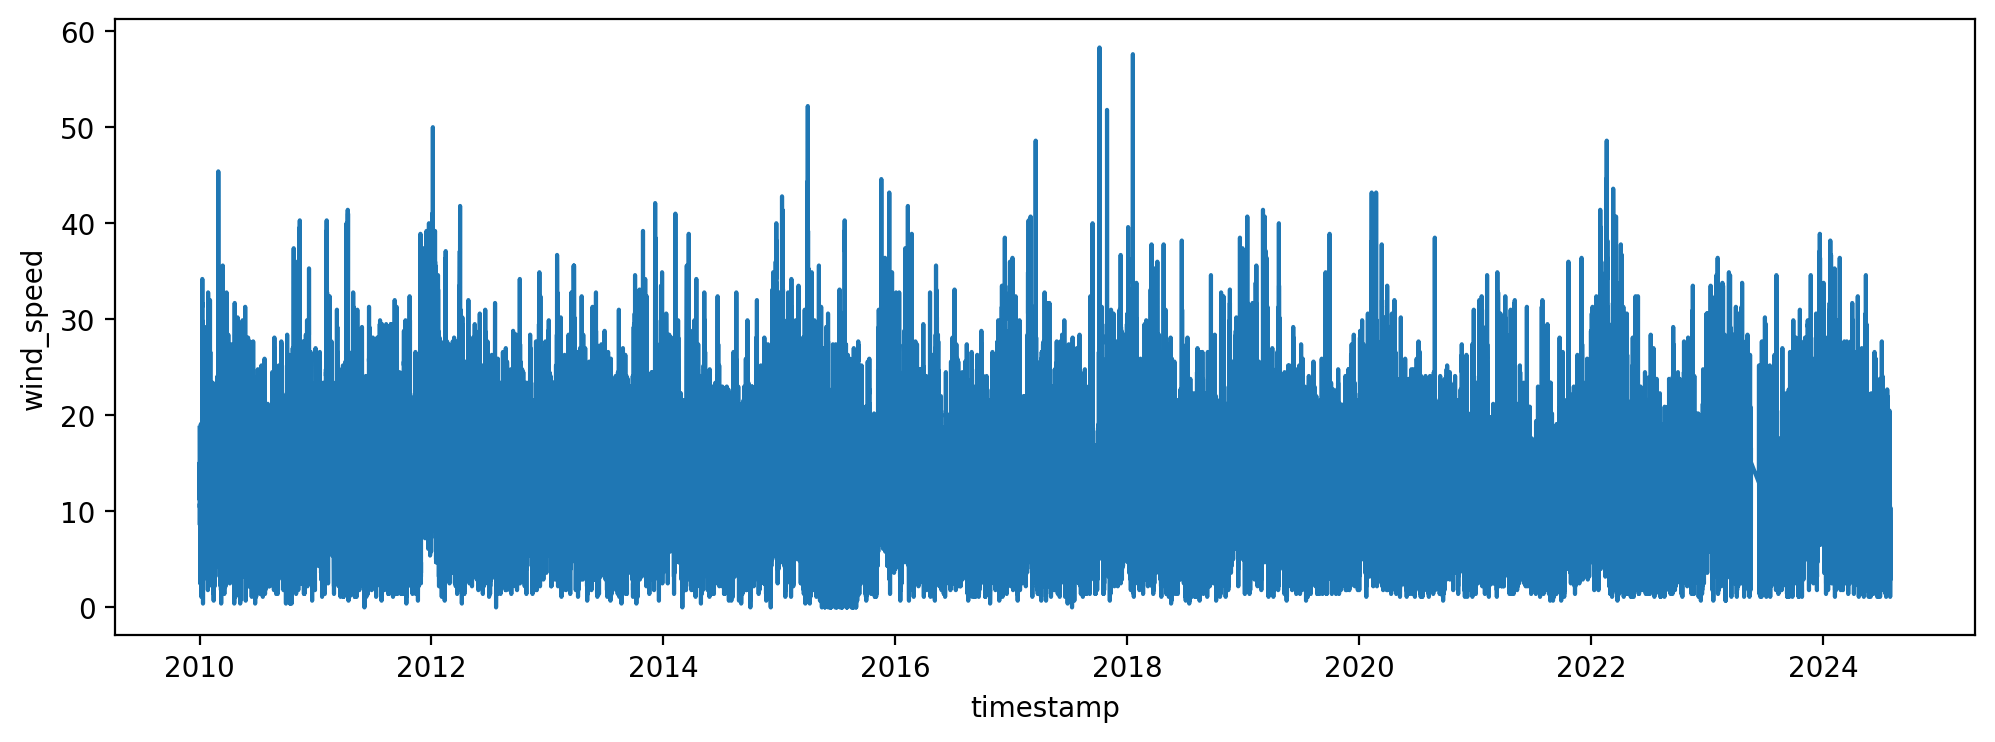

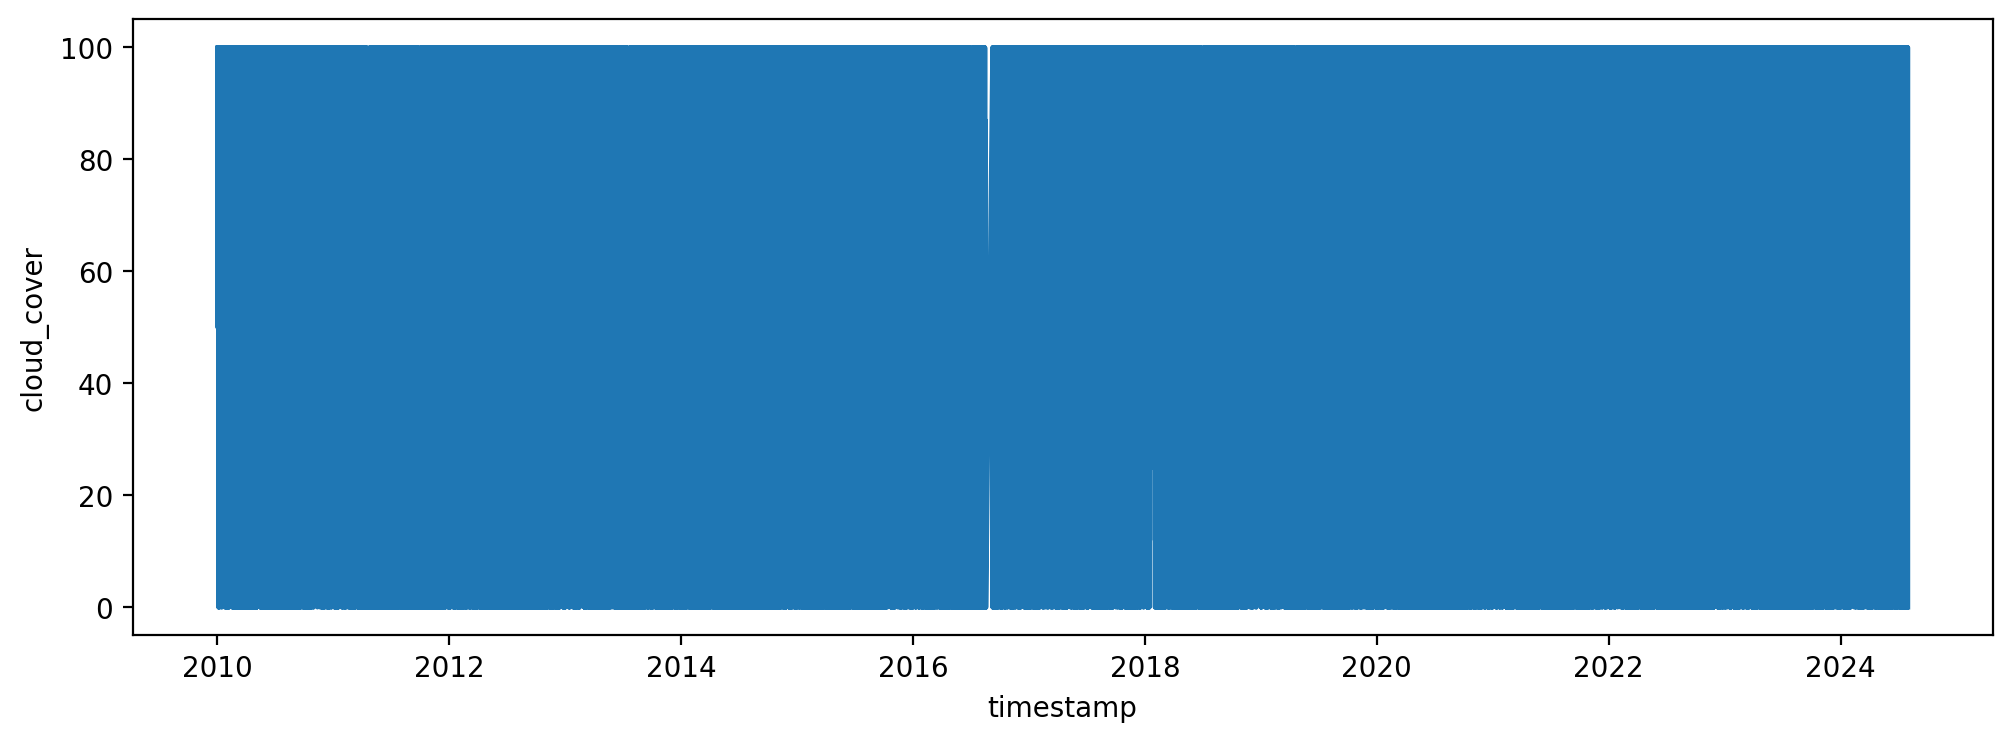

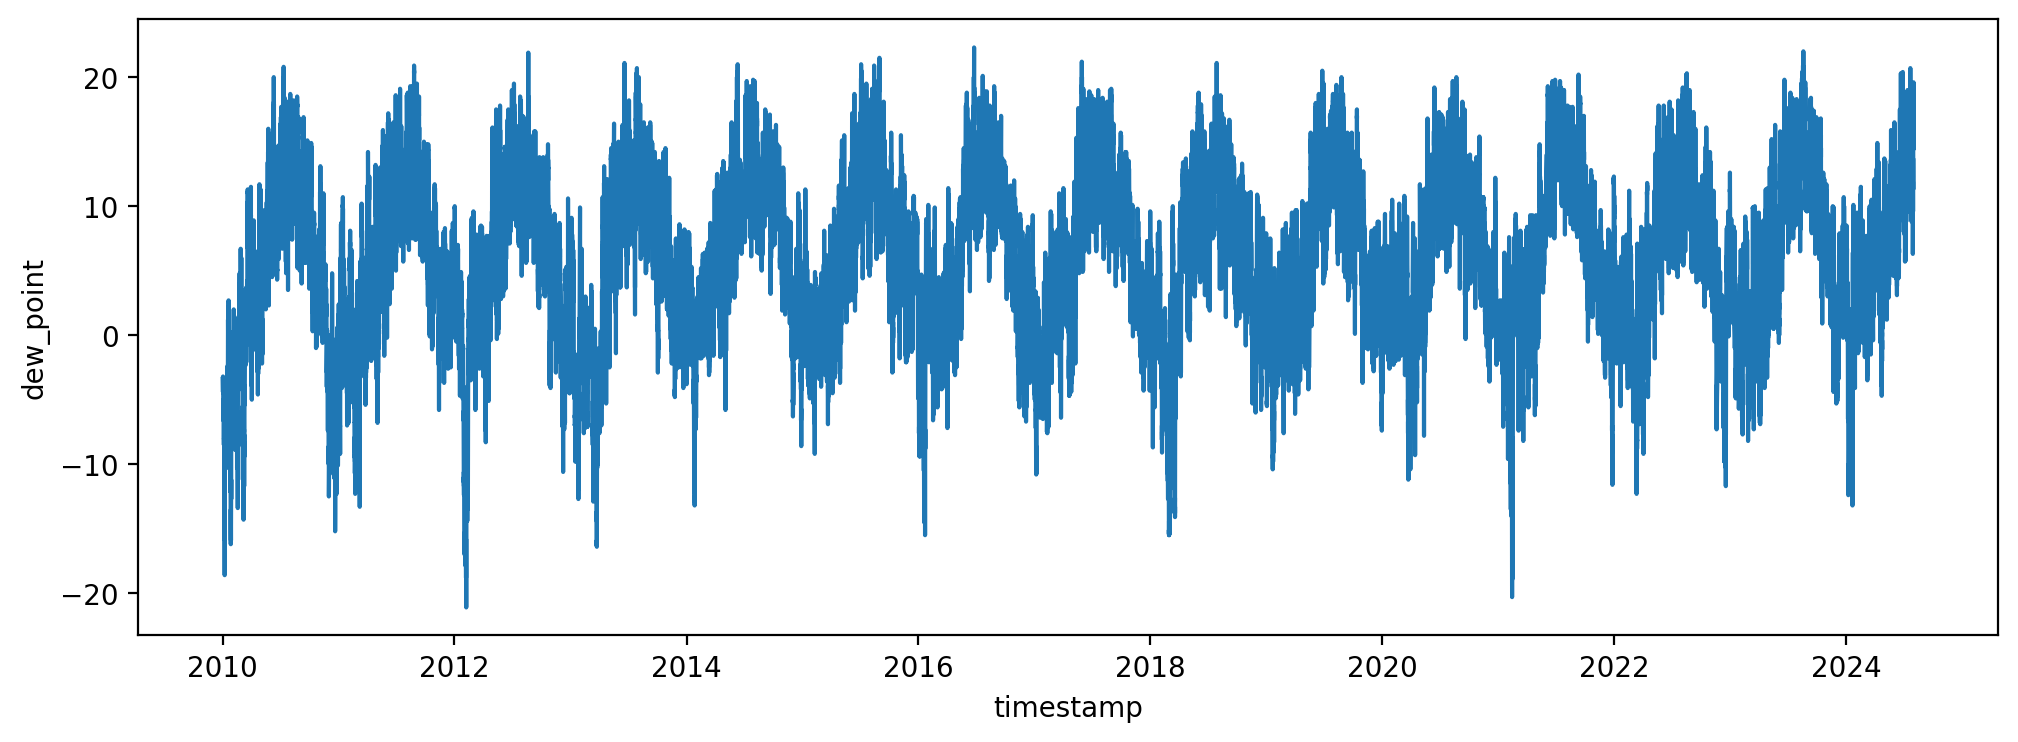

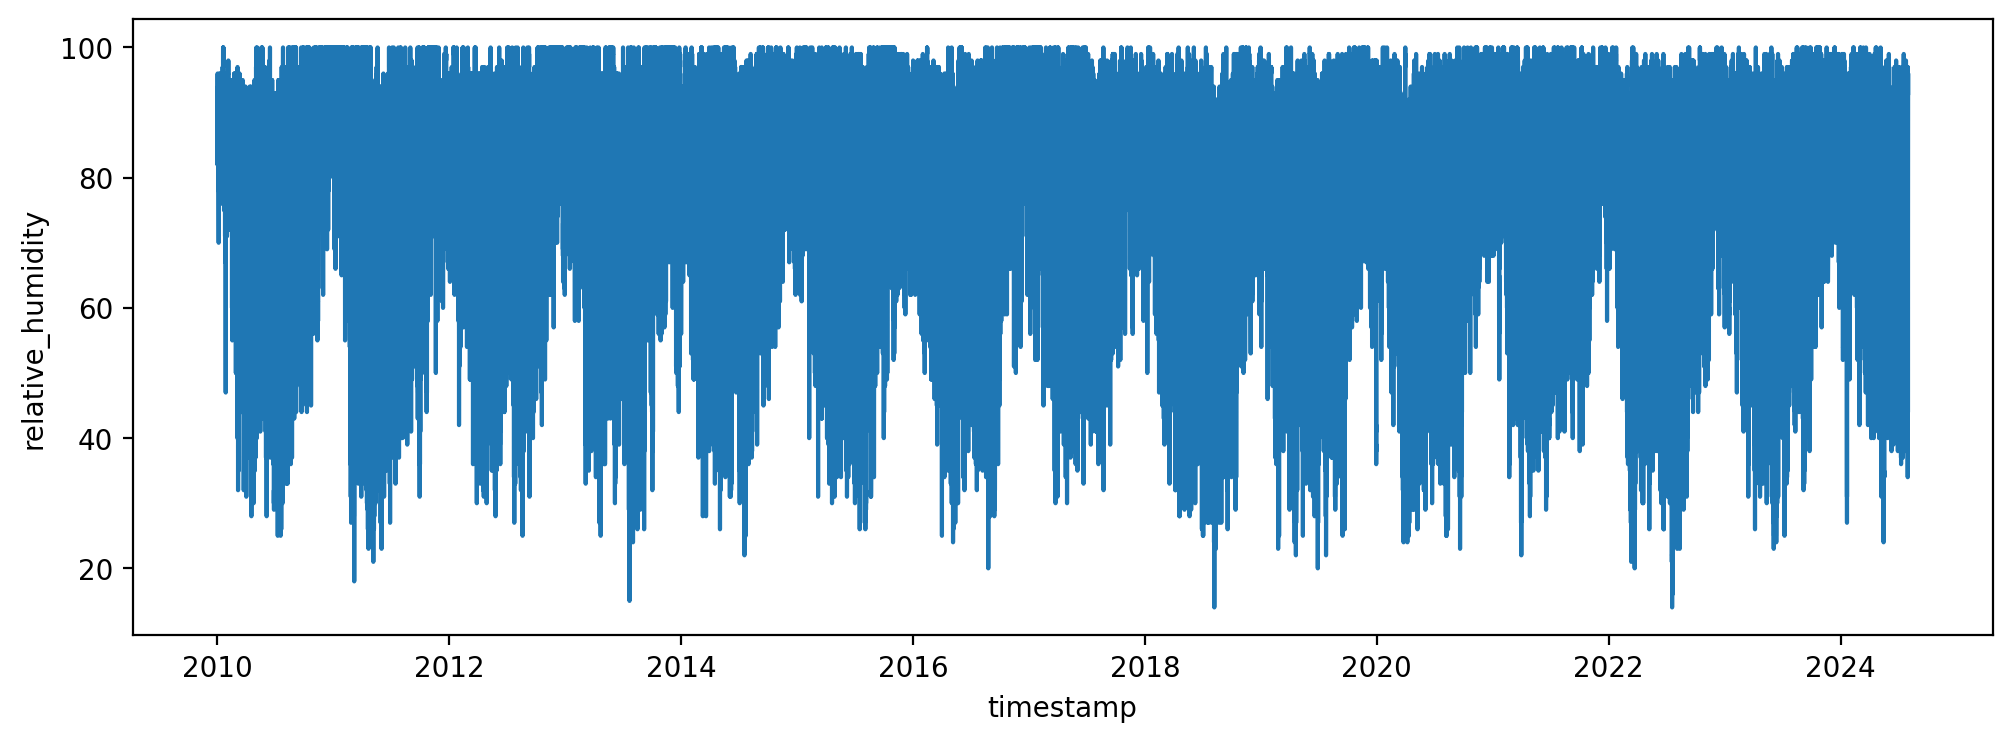

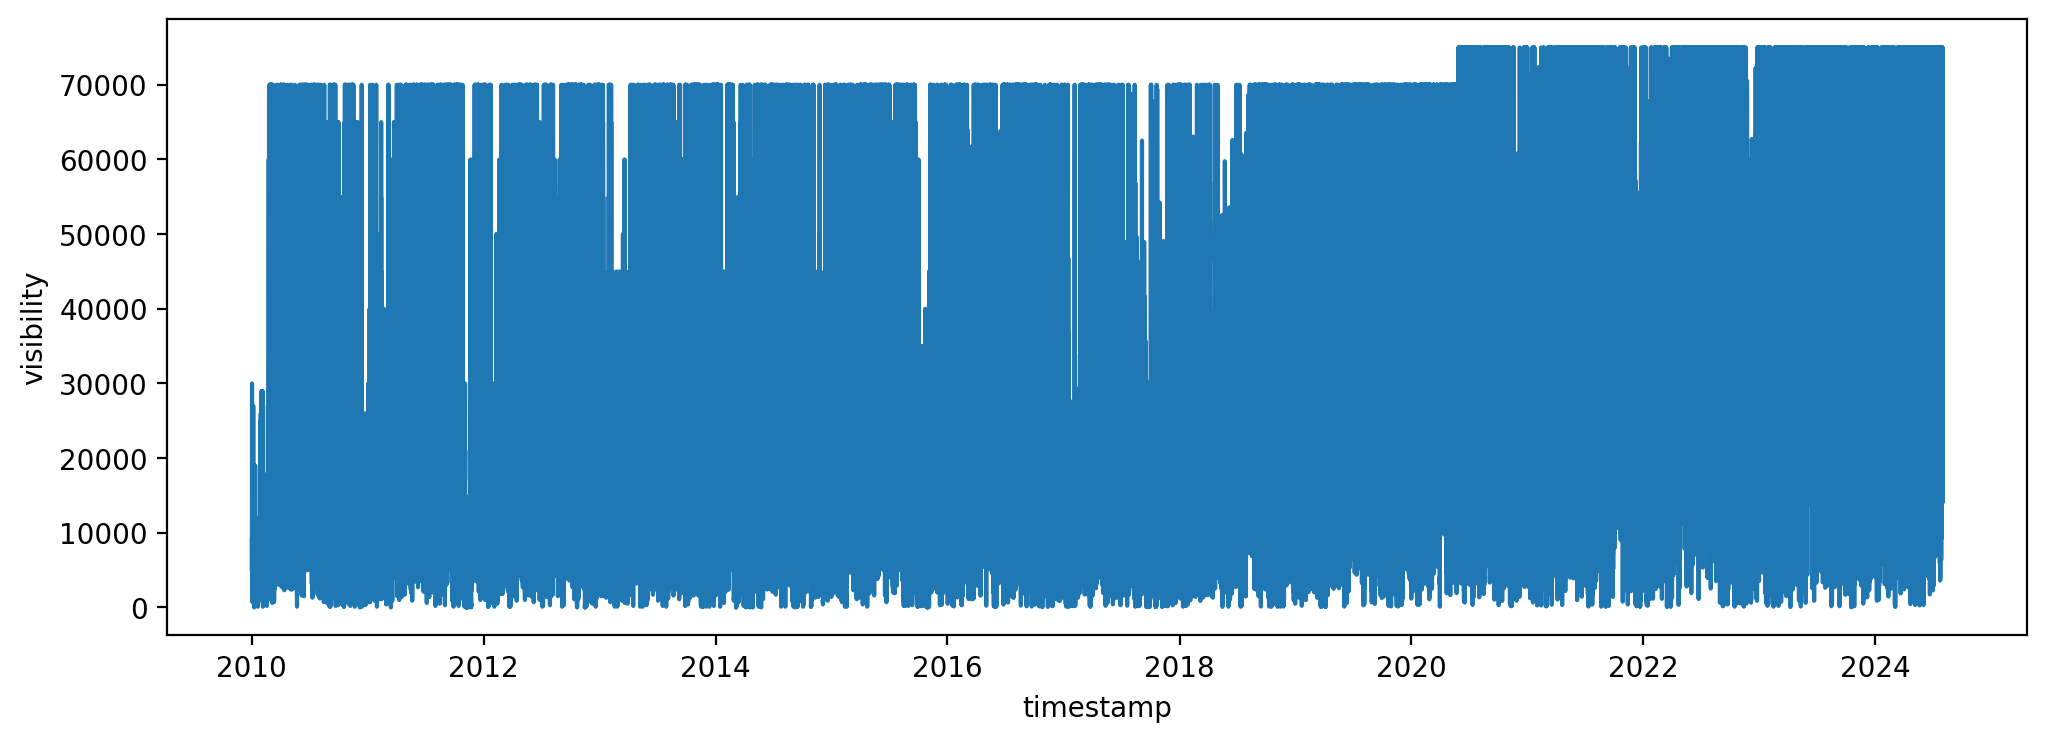

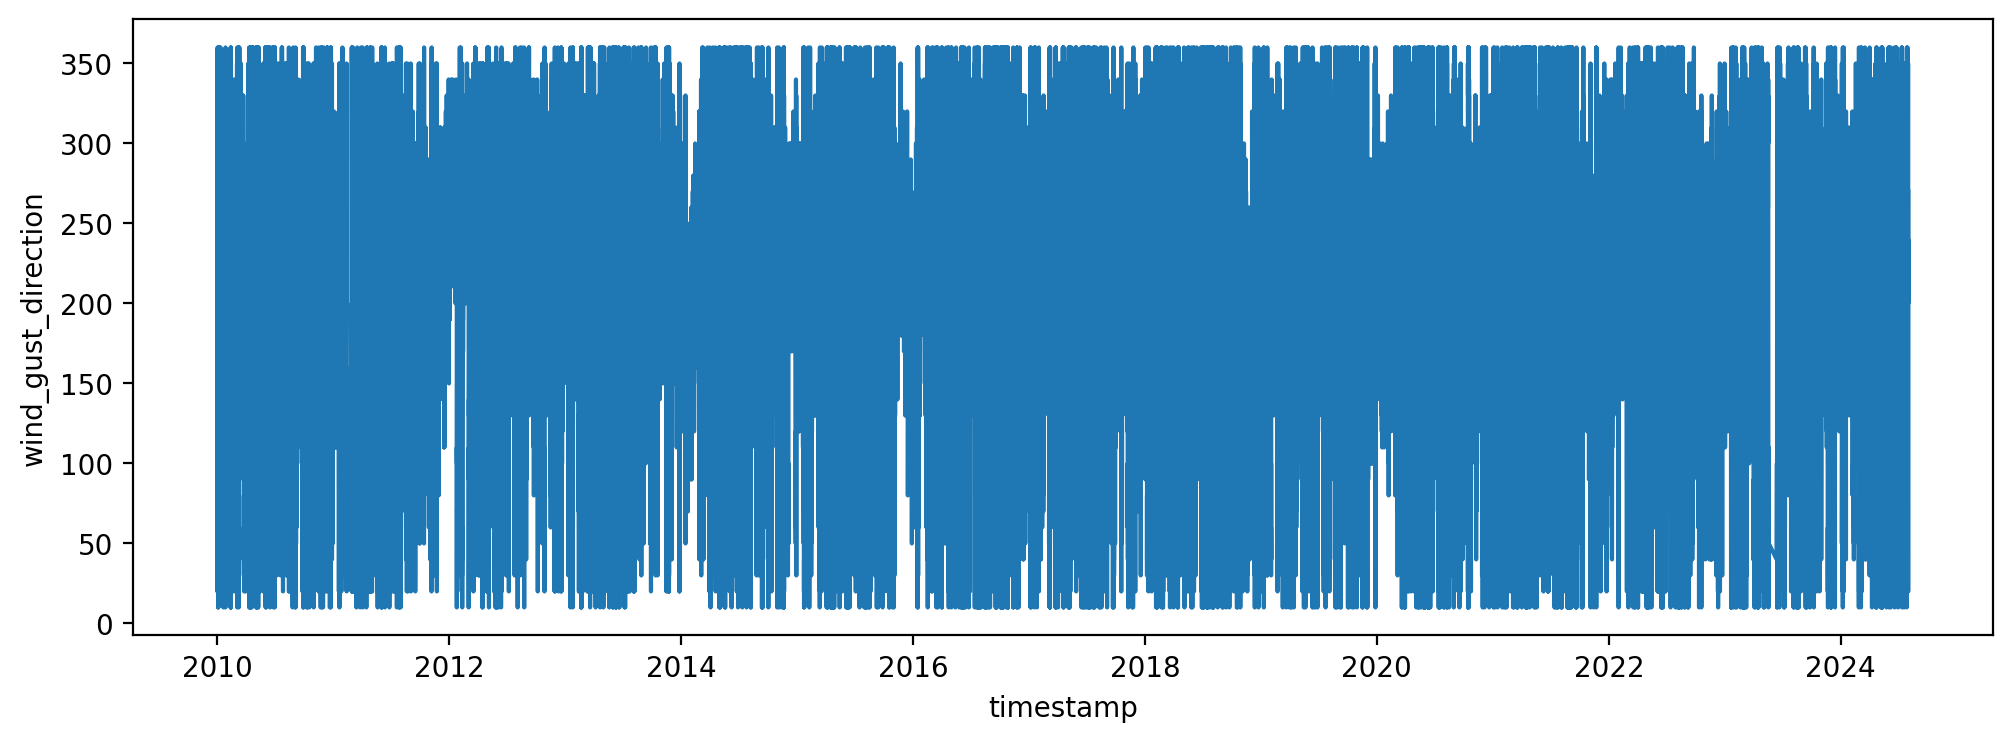

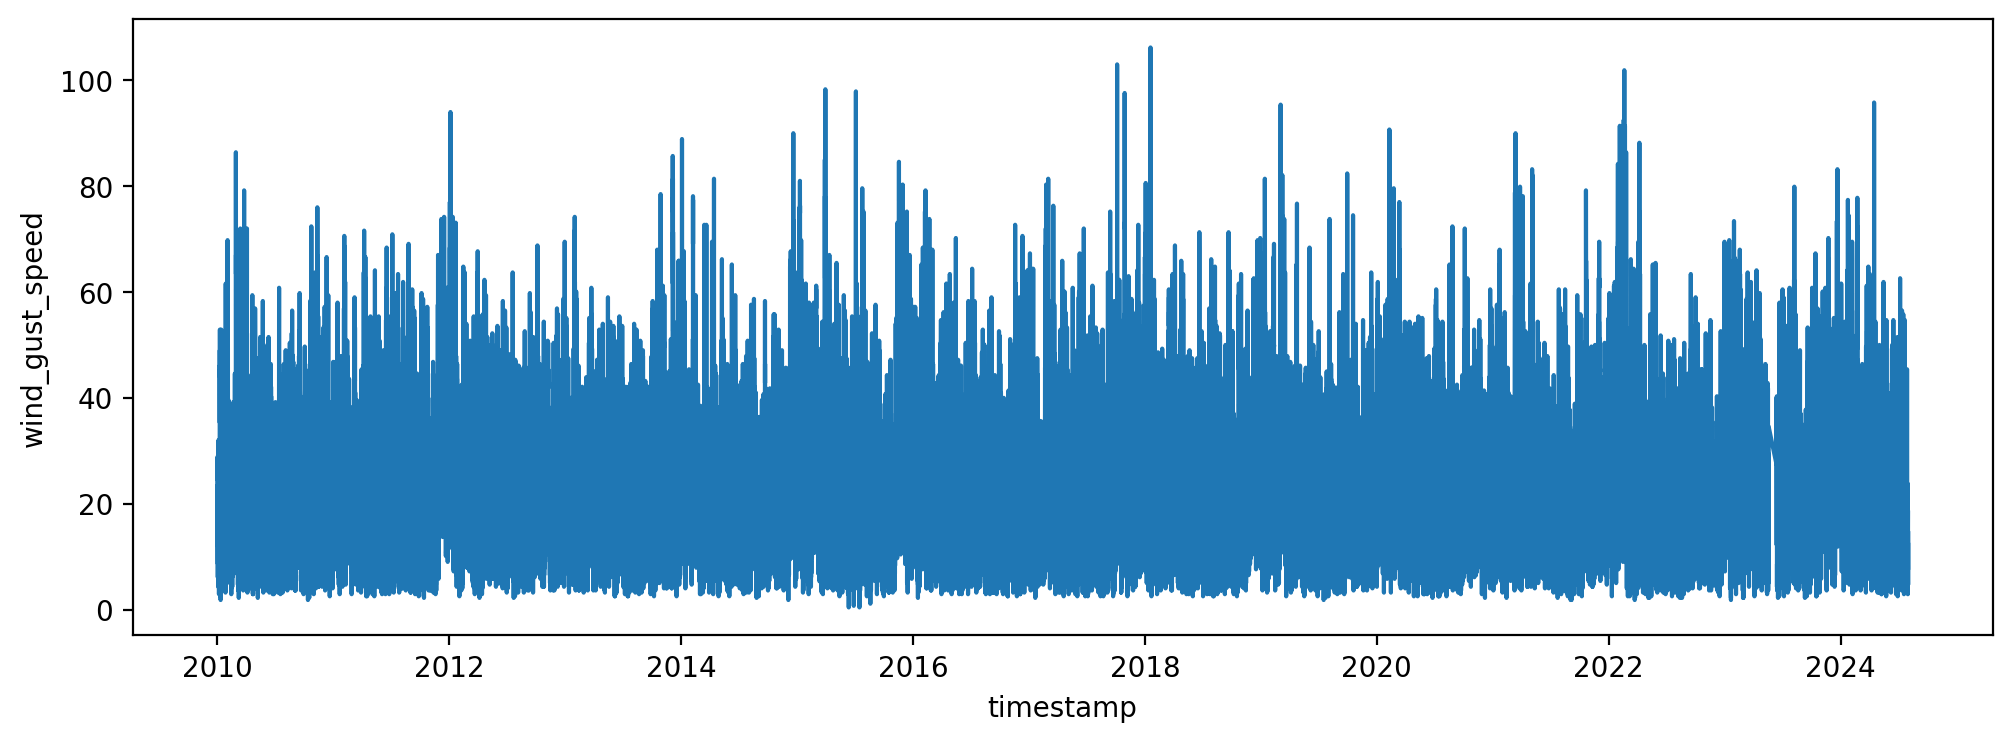

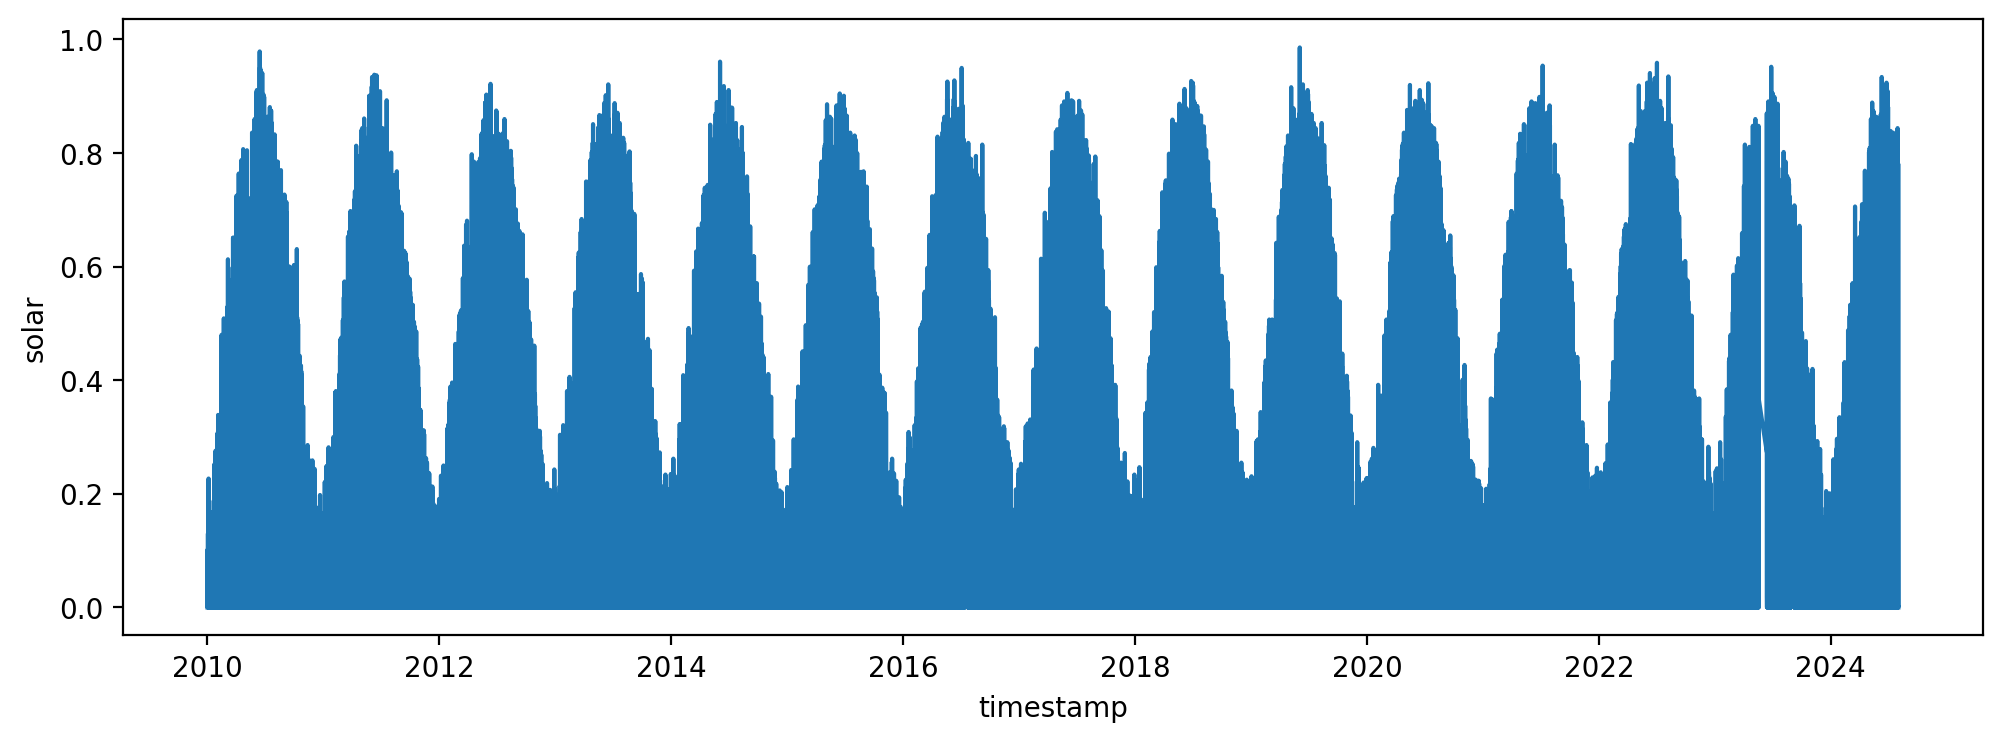

In [21]:
for col in climate_raw.columns:
    fig, ax = plt.subplots(figsize=(12,4))
    sns.lineplot(climate_raw[col], ax=ax)
    plt.show()

## Ohrum

In [50]:
ohrum_data = pd.read_excel(utils.get_raw_path("Ohrum.xlsx"))
ohrum_data

,Datum,Zeit,Waserstand relativ [cm]
0,NaT,NaN,NaN
1,2005-01-01,00:15:00,120
2,2005-01-01,00:30:00,120
3,2005-01-01,00:45:00,120
4,2005-01-01,01:00:00,120
...,...,...,...
686299,2024-07-28,22:45:00,160
686300,2024-07-28,23:00:00,160
686301,2024-07-28,23:15:00,159
686302,2024-07-28,23:30:00,159


In [59]:
ohrum_data = ohrum_data.dropna()

In [60]:
ohrum_data

,Datum,Zeit,Waserstand relativ [cm]
1,2005-01-01,00:15:00,120
2,2005-01-01,00:30:00,120
3,2005-01-01,00:45:00,120
4,2005-01-01,01:00:00,120
5,2005-01-01,01:15:00,120
...,...,...,...
686299,2024-07-28,22:45:00,160
686300,2024-07-28,23:00:00,160
686301,2024-07-28,23:15:00,159
686302,2024-07-28,23:30:00,159


In [66]:
ohrum_str = ohrum_data.astype("str")
ohrum_data.index = pd.to_datetime(ohrum_str["Datum"] + " " + ohrum_str["Zeit"], format="%Y-%m-%d %H:%M:%S")

In [71]:
ohrum_data = ohrum_data.drop(columns=["Datum", "Zeit"])

In [74]:
ohrum_data = ohrum_data.loc[ohrum_data.index.minute == 0]

In [102]:
ohrum_data.value_counts(dropna=True)

Waserstand relativ [cm]
111                        4088
108                        4038
109                        4009
112                        3915
107                        3873
                           ... 
79                            1
80                            1
84                            1
82                            1
 ---                          1
Name: count, Length: 360, dtype: int64

In [103]:
ohrum_data.loc[ohrum_data["Waserstand relativ [cm]"] == " ---"]

,Waserstand relativ [cm]
2018-01-01,---


In [93]:
ohrum_data.loc["2017-12-31 23:00:00"]

Waserstand relativ [cm]    204
Name: 2017-12-31 23:00:00, dtype: object

In [94]:
ohrum_data.loc["2018-01-01 01:00:00"]

Waserstand relativ [cm]    206
Name: 2018-01-01 01:00:00, dtype: object

In [108]:
ohrum_data.loc[ohrum_data["Waserstand relativ [cm]"] == " ---"] = np.mean([ohrum_data.loc["2017-12-31 23:00:00"], ohrum_data.loc["2018-01-01 01:00:00"]])

<Axes: ylabel='Waserstand relativ [cm]'>

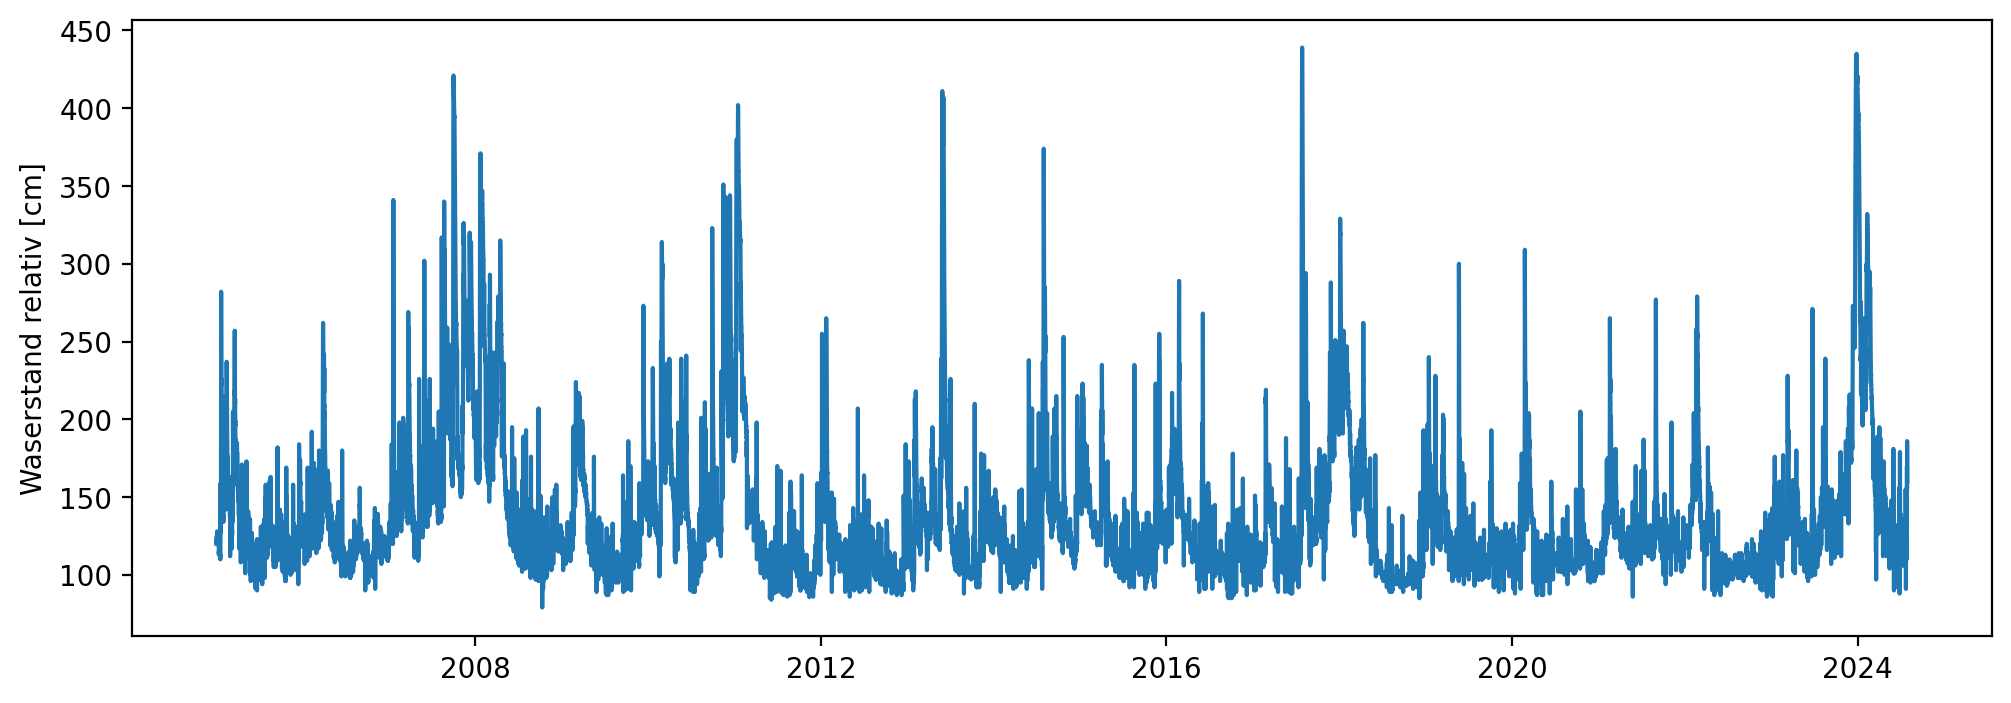

In [110]:
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(ohrum_data["Waserstand relativ [cm]"], ax=ax)

In [116]:
ohrum_data.rename(columns={"Waserstand relativ [cm]": "Waterlevel relative [cm]"})


,Waterlevel relative [cm]
2005-01-01 01:00:00,120
2005-01-01 02:00:00,120
2005-01-01 03:00:00,120
2005-01-01 04:00:00,121
2005-01-01 05:00:00,121
...,...
2024-07-28 19:00:00,168
2024-07-28 20:00:00,166
2024-07-28 21:00:00,164
2024-07-28 22:00:00,161


In [140]:
preprocessed_ohrum_data_csv = preprocess_ohrum_data()

In [141]:
preprocessed_ohrum_data_csv

,Waterlevel relative [cm]
2005-01-01 01:00:00,120.0
2005-01-01 02:00:00,120.0
2005-01-01 03:00:00,120.0
2005-01-01 04:00:00,121.0
2005-01-01 05:00:00,121.0
...,...
2024-07-28 19:00:00,168.0
2024-07-28 20:00:00,166.0
2024-07-28 21:00:00,164.0
2024-07-28 22:00:00,161.0


In [142]:
preprocessed_ohrum_data_csv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 171575 entries, 2005-01-01 01:00:00 to 2024-07-28 23:00:00
Data columns (total 1 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Waterlevel relative [cm]  171575 non-null  float64
dtypes: float64(1)
memory usage: 6.6 MB


In [ ]:
ohrum_csv = get_ohrum_data()

In [119]:
ohrum_csv

,Waterlevel relative [cm]
2005-01-01 01:00:00,120.0
2005-01-01 02:00:00,120.0
2005-01-01 03:00:00,120.0
2005-01-01 04:00:00,121.0
2005-01-01 05:00:00,121.0
...,...
2024-07-28 19:00:00,168.0
2024-07-28 20:00:00,166.0
2024-07-28 21:00:00,164.0
2024-07-28 22:00:00,161.0


In [123]:
ohrum_csv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 171575 entries, 2005-01-01 01:00:00 to 2024-07-28 23:00:00
Data columns (total 1 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Waterlevel relative [cm]  171575 non-null  float64
dtypes: float64(1)
memory usage: 2.6 MB
